Optimizing Peer-to-Peer Lending: Balancing Risk and Profitability through Data-Driven Segmentation.



Importing Libraries

In [8]:

# This script loads all required libraries for data preprocessing,
# feature engineering, model development, evaluation, clustering,
# dimensionality reduction, hyperparameter tuning, and visualisation.
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
import os 

from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder, FunctionTransformer, StandardScaler, LabelEncoder
)
from sklearn.impute import SimpleImputer
from scipy.stats import ttest_ind
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFE, VarianceThreshold
from sklearn.model_selection import (
    train_test_split, cross_validate, cross_val_score, 
    GridSearchCV, RandomizedSearchCV, KFold, StratifiedKFold
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from scipy.stats import ks_2samp

from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, precision_recall_curve, 
    confusion_matrix, classification_report, balanced_accuracy_score, 
    average_precision_score, 
    
)

import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from typing import Dict, List, Tuple, Optional, Union, Any
from pathlib import Path

random_state = 42
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
print("All imports successful")


All imports successful


# Code Implementation

- Data Loading

In [9]:
# 2. Data Ingestion and Initial Exploration
try:
    # Load the dataset
    df = pd.read_csv('C:\\Users\\ADETUNJI\\Documents\\project\\loans_full_schema.csv', na_values=['NA', 'N/A', 'na', 'n/a', 'None', 'none', 'NULL', 'null', '', ' ...'])
    print("Dataset loaded successfully.")
    print("Shape of the dataset:", df.shape)

    print("\nInitial DataFrame Info:")
    df.info()

    print("\nFirst 5 rows of the dataset:")
    print(df.head())

    print("\nSummary statistics for numerical columns:")
    print(df.describe()) #   Column                                      Non-Null Count  Dtype  

except FileNotFoundError:
    print("Error: 'loans_full_schema.csv' not found. Please ensure the file is in the correct directory.")
    exit()

Dataset loaded successfully.
Shape of the dataset: (10000, 55)

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 55 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   emp_title                                   10000 non-null  object 
 1    emp_length                                 10000 non-null  object 
 2    state                                      10000 non-null  object 
 3    homeownership                              10000 non-null  object 
 4    annual_income                              10000 non-null  float64
 5    verified_income                            10000 non-null  object 
 6    debt_to_income                             10000 non-null  object 
 7    annual_income_joint                        10000 non-null  object 
 8    verification_income_joint                  10000 non-null  object 
 

#### Data Cleaning

In [10]:
# Remove leading/trailing whitespace from all column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

# Print the cleaned column names to verify
print("Cleaned column names:")
df_clean = df.copy()

Cleaned column names:


In [11]:
df.loan_amount.sum()

np.int64(163619225)

In [12]:
#check for duplicate values
duplicate_rows = df_clean.duplicated().sum()
if duplicate_rows > 0:
    print(f"\nFound and removed {duplicate_rows} duplicate rows.")
    df.drop_duplicates(inplace=True)
else:
    print("\nNo duplicate rows found.")


No duplicate rows found.


In [13]:
# checking data types
df_clean.dtypes

emp_title                            object
emp_length                           object
state                                object
homeownership                        object
annual_income                       float64
verified_income                      object
debt_to_income                       object
annual_income_joint                  object
verification_income_joint            object
debt_to_income_joint                 object
delinq_2y                             int64
months_since_last_delinq             object
earliest_credit_line                  int64
inquiries_last_12m                    int64
total_credit_lines                    int64
open_credit_lines                     int64
total_credit_limit                    int64
total_credit_utilized                 int64
num_collections_last_12m              int64
num_historical_failed_to_pay          int64
months_since_90d_late                object
current_accounts_delinq               int64
total_collection_amount_ever    

In [14]:
# Select only numeric columns using select_dtypes
# they are some badly written data in this columns which are numeric but usually seen as objects
numeric = ['emp_length','debt_to_income','months_since_90d_late','months_since_last_credit_inquiry','num_accounts_120d_past_due']

# Convert mixed type columns to numeric, coercing errors
for col in numeric:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

numeric_df = df_clean.select_dtypes(include=['int64', 'float64'])



# Display the shape of the numeric dataframe
print("Shape of numeric dataframe:", numeric_df.shape)

# Display the column names of numeric dataframe
print("\nNumeric columns:")
print(numeric_df.columns.tolist())

Shape of numeric dataframe: (10000, 39)

Numeric columns:
['emp_length', 'annual_income', 'debt_to_income', 'delinq_2y', 'earliest_credit_line', 'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines', 'total_credit_limit', 'total_credit_utilized', 'num_collections_last_12m', 'num_historical_failed_to_pay', 'months_since_90d_late', 'current_accounts_delinq', 'total_collection_amount_ever', 'current_installment_accounts', 'accounts_opened_24m', 'months_since_last_credit_inquiry', 'num_satisfactory_accounts', 'num_accounts_120d_past_due', 'num_accounts_30d_past_due', 'num_active_debit_accounts', 'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts', 'num_cc_carrying_balance', 'num_mort_accounts', 'account_never_delinq_percent', 'tax_liens', 'public_record_bankrupt', 'loan_amount', 'term', 'interest_rate', 'installment', 'balance', 'paid_total', 'paid_principal', 'paid_interest', 'paid_late_fees']


In [15]:
# For numeric columns, convert to string, strip whitespace, and convert back to numeric
for col in numeric_df.columns:
    # Only process if the column is in the dataframe
    if col in df_clean.columns:
        # Convert to string, strip whitespace, and convert back to numeric
        df_clean[col] = pd.to_numeric(df_clean[col].astype(str).str.strip(), errors='coerce').round(2)
        
print("Whitespace removed from numeric column values")
print("Shape of dataframe:", df_clean.shape)

Whitespace removed from numeric column values
Shape of dataframe: (10000, 55)


In [16]:
# For object and category columns, convert to string, strip whitespace.
object_df = df_clean.select_dtypes(include=['object', 'category'])
for col in object_df.columns:
    # Only process if the column is in the dataframe
    if col in df_clean.columns:
        # Convert to string, strip whitespace
        df_clean[col] = df_clean[col].astype(str).str.strip().str.lower()
        
print("Whitespace objects from numeric column values")
print("Shape of dataframe:", df_clean.shape)

Whitespace objects from numeric column values
Shape of dataframe: (10000, 55)


In [17]:
# Function to replace missing values with pd.NA
def replace_missing_with_pdna(df):
    """
    Replace missing values with pd.NA for different datatypes in a DataFrame
    Parameters:
    df : pandas.DataFrame
    Input DataFrame containing missing values
    Returns:
    pandas.DataFrame
        DataFrame with missing values replaced by pd.NA
    """
    
    # Create a copy to avoid modifying the original DataFrame
    df_clean = df.copy()
    
    # Replace different types of missing values with pd.NA
    for column in df_clean.columns:
        # Get the dtype of the column
        dtype = df_clean[column].dtype
        
        if pd.api.types.is_numeric_dtype(dtype):
            # Replace numeric missing values
            df_clean[column] = df_clean[column].replace([np.nan, np.inf, -np.inf,
                                                         'NA', 'N/A', 'na', 'n/a', 'None', 'none', 'NULL', 'null', '', ' ...'], np.nan)
        
        elif pd.api.types.is_string_dtype(dtype):
            # Replace string missing values
            df_clean[column] = df_clean[column].replace(['', 'nan', 'NULL', 'null',
                                                         'NA', 'N/A', 'na', 'n/a', 'None', 'none', 'NULL', 'null', ''], np.nan)
        
        elif pd.api.types.is_datetime64_dtype(dtype):
            # Replace datetime missing values
            df_clean[column] = df_clean[column].replace([pd.NaT], pd.NA)
            
    return df_clean

# Example usage:
df_clean = replace_missing_with_pdna(df_clean)

Feature Engineering

In [18]:
# Keywords for job categories
JOB_CATEGORIES = {
    'Management': ['manager', 'director', 'supervisor', 'lead', 'president', 'vp', 'ceo'],
    'Medical': ['nurse', 'rn', 'doctor', 'physician', 'cna', 'medical', 'healthcare'],
    'Teacher': ['teacher', 'educator', 'instructor', 'professor', 'faculty'],
    'Engineer': ['engineer', 'developer', 'software', 'architect'],
    'Driver': ['driver', 'truck', 'cdl'],
    'Sales': ['sales', 'account executive', 'sales representative'],
    'Admin': ['assistant', 'admin', 'clerk', 'coordinator', 'office'],
    'Analyst': ['analyst'],
    'Technician': ['technician'],
    'Police/Fire': ['officer', 'police', 'firefighter', 'sheriff', 'trooper', 'ems', 'paramedic'],
    'Skilled Trade': ['mechanic', 'electrician', 'welder', 'machinist', 'plumber', 'toolmaker'],
}

def categorize_job_title(title):
    if pd.isna(title):
        return 'Unknown'
    
    title_lower = title.lower()
    for category, keywords in JOB_CATEGORIES.items():
        if any(keyword in title_lower for keyword in keywords):
            return category

    return 'Other'
df_clean['emp_category'] = df_clean['emp_title'].apply(categorize_job_title)
df_clean['emp_category'] = df_clean['emp_category'].replace({
    'Other': 'Other_Unknown',
    'Unknown': 'Other_Unknown'
})

print("Unique categories:", df_clean['emp_category'].nunique())
print(df_clean['emp_category'].value_counts())



Unique categories: 12
emp_category
Other_Unknown    4570
Management       2325
Admin             731
Medical           495
Teacher           345
Engineer          336
Driver            306
Sales             274
Analyst           212
Technician        198
Skilled Trade     157
Police/Fire        51
Name: count, dtype: int64


In [19]:
# drop employment title column
df_clean.drop('emp_title', axis=1, inplace=True)

In [20]:
# concentration is on loans lower or equal to $40,000
df_clean = df_clean[df_clean['loan_amount'] <= 40000]
df_clean.shape

(10000, 55)

In [21]:
# 2. filter tot selct just the individual loans
df_clean= df_clean.query('application_type == "individual"')

In [22]:
df_clean.application_type.value_counts()    

application_type
individual    8505
Name: count, dtype: int64

In [23]:
df_clean.loan_amount.sum()

np.int64(133943925)

In [24]:
# 1. Get the list of all columns that contain the word 'joint'
joint_cols = df_clean.columns[df_clean.columns.str.contains('joint')].tolist()

# 2. Add the 'application_type' column to that list
cols_to_drop = joint_cols

# 3. Now, drop all columns in that list at once
# We add errors='ignore' in case a column was already dropped
df_clean.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# 4. Check the new shape
print(df_clean.shape)

(8505, 52)


In [25]:
# checking the target variable unique values
df_clean.loan_status.unique()
# customers in the current status might possibly be in the delinquency under two years,

array(['current', 'fully paid', 'in grace period', 'late (31-120 days)',
       'charged off', 'late (16-30 days)'], dtype=object)

In [26]:
# check the loan status
df_clean.loan_status = df_clean.loan_status.str.lower()

### Feature Engineering

In [27]:
# Correctly create binary target is_default  and non default
# Mark as default if loan_status is in known default/late categories
# or if loan is 'Current' but has recent delinquencies (delinq_2y > 0)
default_statuses = [
    'charged off', 'late (31-120 days)', 'late (16-30 days)',
    'default', 'in grace period'
]
non_default_statuses = [
    'current', 'fully paid'
]

df_clean['is_default'] = (
    df_clean['loan_status'].isin(default_statuses) 
   
).astype(int)


print("is_default value counts:")
print(df_clean['is_default'].value_counts())
print(f"Default rate: {df_clean['is_default'].mean()*100:.2f}%")

is_default value counts:
is_default
0    8364
1     141
Name: count, dtype: int64
Default rate: 1.66%


In [28]:
### using grade the target prediction since loan datset is hihghly imbalanced
for i in range (len(df_clean)):
    if df_clean['grade'].iloc[i] in ['a','b','c']:
        df_clean['grade'].iloc[i] = 0
    else:
        df_clean['grade'].iloc[i] = 1

In [29]:
# Select object (categorical) columns
df_clean.select_dtypes(include=['object']).columns

Index(['state', 'homeownership', 'verified_income', 'months_since_last_delinq',
       'loan_purpose', 'application_type', 'grade', 'sub_grade', 'issue_month',
       'loan_status', 'initial_listing_status', 'disbursement_method',
       'emp_category'],
      dtype='object')

In [30]:
# Convert string to datetime
df_clean['issue_month'] = pd.to_datetime(df_clean['issue_month'], format='%b-%Y')

In [31]:
# Extract year and month
df_clean['year'] = df_clean['issue_month'].dt.year
df_clean['month'] = df_clean['issue_month'].dt.month

print(df_clean[['issue_month', 'year', 'month']])

     issue_month  year  month
0     2018-03-01  2018      3
1     2018-02-01  2018      2
2     2018-02-01  2018      2
3     2018-01-01  2018      1
5     2018-01-01  2018      1
...          ...   ...    ...
9994  2018-03-01  2018      3
9995  2018-01-01  2018      1
9996  2018-02-01  2018      2
9998  2018-02-01  2018      2
9999  2018-02-01  2018      2

[8505 rows x 3 columns]


In [32]:
# too much cardinality in state column, mow binned
df_clean.state.str.strip().unique()
# 1. Define your "bins" (regions)
region_map = {
    'Northeast': ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA'],
    'Midwest': ['IL', 'IN', 'MI', 'OH', 'WI', 'IA', 'KS', 'MN', 'MO', 'NE', 'ND', 'SD'],
    'South': ['DE', 'FL', 'GA', 'MD', 'NC', 'SC', 'VA', 'DC', 'WV', 'AL', 'KY', 'MS', 'TN', 'AR', 'LA', 'OK', 'TX'],
    'West': ['AZ', 'CO', 'ID', 'MT', 'NV', 'NM', 'UT', 'WY', 'AK', 'CA', 'HI', 'OR', 'WA']
}

# Invert the map for easier lookup
state_to_region = {state: region for region, states in region_map.items() for state in states}

# 2. Map the states to their new "bin"
df_clean['region'] = df_clean['state'].map(state_to_region)

Exploratory Data Analysis (EDA)

In [33]:
df_clean.select_dtypes(include=['number']).columns

Index(['emp_length', 'annual_income', 'debt_to_income', 'delinq_2y',
       'earliest_credit_line', 'inquiries_last_12m', 'total_credit_lines',
       'open_credit_lines', 'total_credit_limit', 'total_credit_utilized',
       'num_collections_last_12m', 'num_historical_failed_to_pay',
       'months_since_90d_late', 'current_accounts_delinq',
       'total_collection_amount_ever', 'current_installment_accounts',
       'accounts_opened_24m', 'months_since_last_credit_inquiry',
       'num_satisfactory_accounts', 'num_accounts_120d_past_due',
       'num_accounts_30d_past_due', 'num_active_debit_accounts',
       'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts',
       'num_cc_carrying_balance', 'num_mort_accounts',
       'account_never_delinq_percent', 'tax_liens', 'public_record_bankrupt',
       'loan_amount', 'term', 'interest_rate', 'installment', 'balance',
       'paid_total', 'paid_principal', 'paid_interest', 'paid_late_fees',
       'is_default', 'year', '

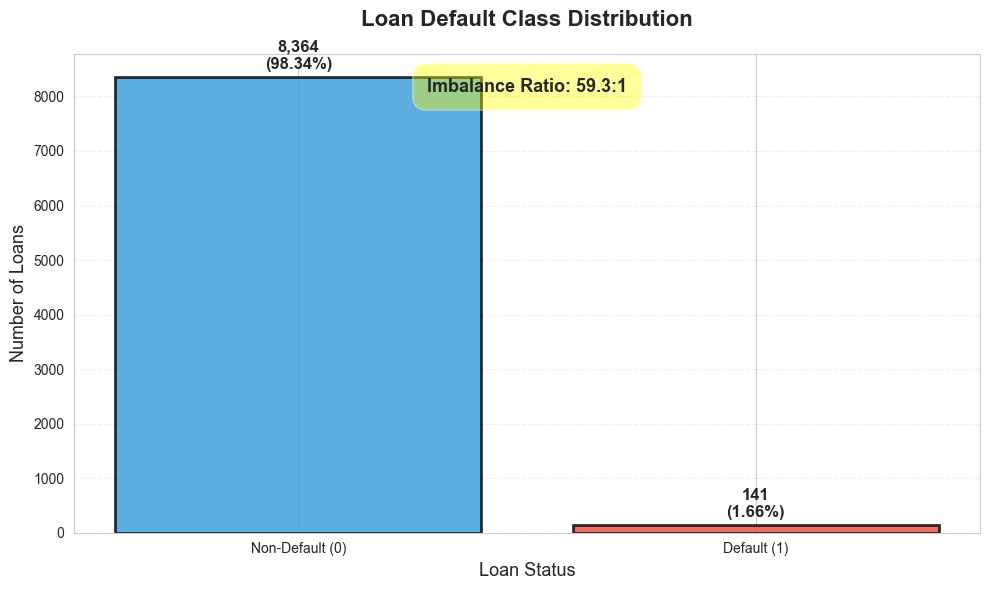


Class Distribution:
Non-Default: 8,364 (98.34%)
Default: 141 (1.66%)
Imbalance Ratio: 59.32:1


In [34]:
# Simple, clean single visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Get counts and percentages
counts = df_clean['is_default'].value_counts()
total = len(df_clean)
percentages = (counts / total * 100).round(2)

# Create bar chart
colors = ['#3498db', '#e74c3c']
bars = ax.bar(['Non-Default (0)', 'Default (1)'], counts.values, 
              color=colors, edgecolor='black', linewidth=2, alpha=0.8)

# Add labels
ax.set_title('Loan Default Class Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Number of Loans', fontsize=13)
ax.set_xlabel('Loan Status', fontsize=13)

# Add count and percentage labels on bars
for i, (bar, count, pct) in enumerate(zip(bars, counts.values, percentages.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + total*0.01,
            f'{count:,}\n({pct:.2f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add imbalance ratio annotation
ratio = counts[0] / counts[1]
ax.text(0.5, 0.95, f'Imbalance Ratio: {ratio:.1f}:1', 
        transform=ax.transAxes, ha='center', va='top',
        fontsize=13, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='yellow', alpha=0.4))

# Add grid for readability
ax.yaxis.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# Print summary
print(f"\nClass Distribution:")
print(f"Non-Default: {counts[0]:,} ({percentages[0]:.2f}%)")
print(f"Default: {counts[1]:,} ({percentages[1]:.2f}%)")
print(f"Imbalance Ratio: {ratio:.2f}:1")

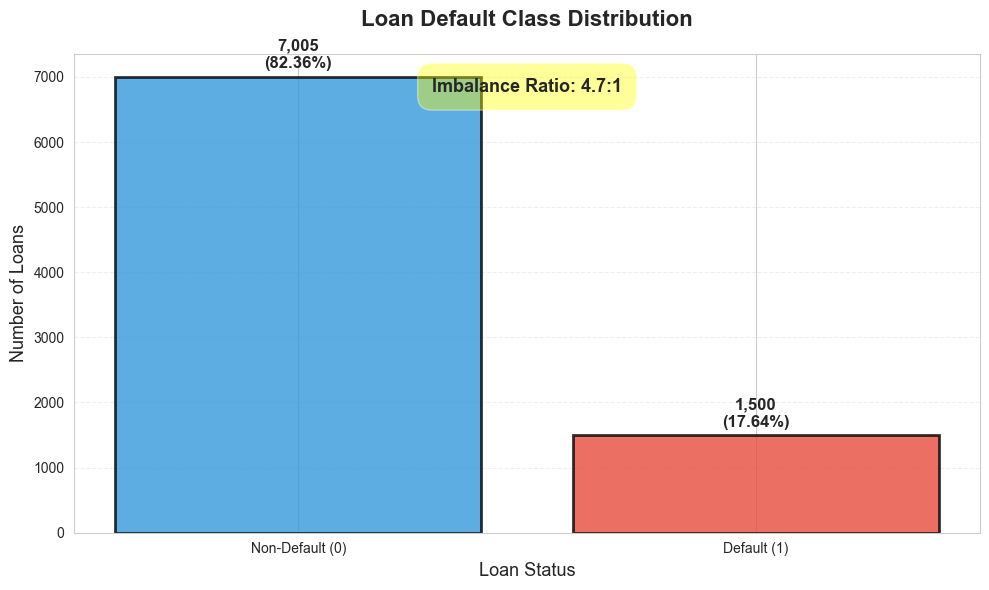


Class Distribution:
Non-Default: 7,005 (82.36%)
Default: 1,500 (17.64%)
Imbalance Ratio: 4.67:1


In [35]:
# Checking the imbalance ratio in loan grade
# Simple, clean single visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Get counts and percentages
counts = df_clean['grade'].value_counts()
total = len(df_clean)
percentages = (counts / total * 100).round(2)

# Create bar chart
colors = ['#3498db', '#e74c3c']
bars = ax.bar(['Non-Default (0)', 'Default (1)'], counts.values,
              color=colors, edgecolor='black', linewidth=2, alpha=0.8)

# Add labels
ax.set_title('Loan Default Class Distribution', fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Number of Loans', fontsize=13)
ax.set_xlabel('Loan Status', fontsize=13)

# Add count and percentage labels on bars
for i, (bar, count, pct) in enumerate(zip(bars, counts.values, percentages.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height + total * 0.01,
            f'{count:,}\n({pct:.2f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Add imbalance ratio annotation
ratio = counts[0] / counts[1]
ax.text(0.5, 0.95, f'Imbalance Ratio: {ratio:.1f}:1',
        transform=ax.transAxes, ha='center', va='top',
        fontsize=13, fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.8', facecolor='yellow', alpha=0.4))

# Add grid for readability
ax.yaxis.grid(True, alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# Print summary
print(f"\nClass Distribution:")
print(f"Non-Default: {counts[0]:,} ({percentages[0]:.2f}%)")
print(f"Default: {counts[1]:,} ({percentages[1]:.2f}%)")
print(f"Imbalance Ratio: {ratio:.2f}:1")

Due to the highly imbalance ratio of loan status, default is less than 2%, loan status will be used for my non default and default selection.

In [36]:
# drop the loan status converted to target
df_clean.drop(columns= ['is_default'], inplace = True)

In [37]:
# create a new target variable
df_clean['loan_grade_status'] = df_clean['grade']

In [38]:
# Summary statistics for numerical features
numerical_features = df_clean.select_dtypes(include=[np.number]).columns.tolist()
print("Summary Statistics for Numerical Features:")
df_clean[numerical_features].describe().T

Summary Statistics for Numerical Features:


,count,mean,std,min,25%,50%,75%,max
emp_length,7890.0,5.882636,3.711236,0.00,2.00,6.00,10.00,10.00
annual_income,8505.0,82321.917529,67064.764552,5235.00,48000.00,68200.00,100000.00,2300000.00
debt_to_income,8505.0,17.339407,8.756774,0.00,10.72,16.79,23.38,39.99
delinq_2y,8505.0,0.216696,0.692626,0.00,0.00,0.00,0.00,13.00
earliest_credit_line,8505.0,2001.434450,7.743945,1963.00,1998.00,2003.00,2006.00,2015.00
inquiries_last_12m,8505.0,1.960847,2.364582,0.00,0.00,1.00,3.00,29.00
total_credit_lines,8505.0,22.677366,11.925967,2.00,14.00,21.00,29.00,87.00
open_credit_lines,8505.0,11.452322,5.914916,0.00,7.00,10.00,15.00,51.00
total_credit_limit,8505.0,175983.150617,186210.230164,0.00,49000.00,105538.00,254999.00,3386034.00
total_credit_utilized,8505.0,49921.791182,53885.474379,0.00,18703.00,35446.00,63235.00,942456.00



Column: emp_length
Summary statistics:
count    7890.0000
mean        5.8826
std         3.7112
min         0.0000
25%         2.0000
50%         6.0000
75%        10.0000
max        10.0000
Name: emp_length, dtype: float64
Missing: 615 (7.23%)  |  Skewness: -0.140


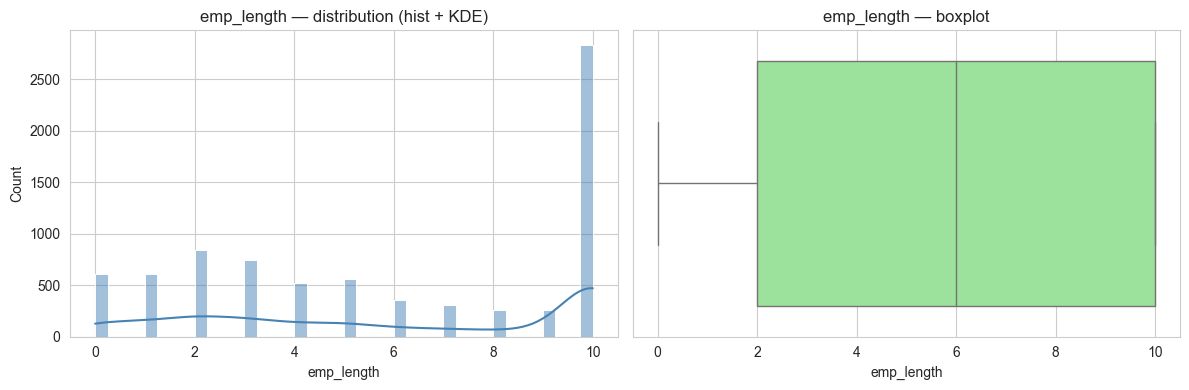

Interpretation:
- Column has 7.2% missing values which may require imputation.
- Mean and median are similar -> distribution roughly symmetric.
- Distribution approximately symmetric (low skew).
- Employment length may be noisy; consider binning into categories (e.g., <1, 1-3, 4-10, >10 years).

Column: annual_income
Summary statistics:
count    8.505000e+03
mean     8.232192e+04
std      6.706476e+04
min      5.235000e+03
25%      4.800000e+04
50%      6.820000e+04
75%      1.000000e+05
max      2.300000e+06
Name: annual_income, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 9.273


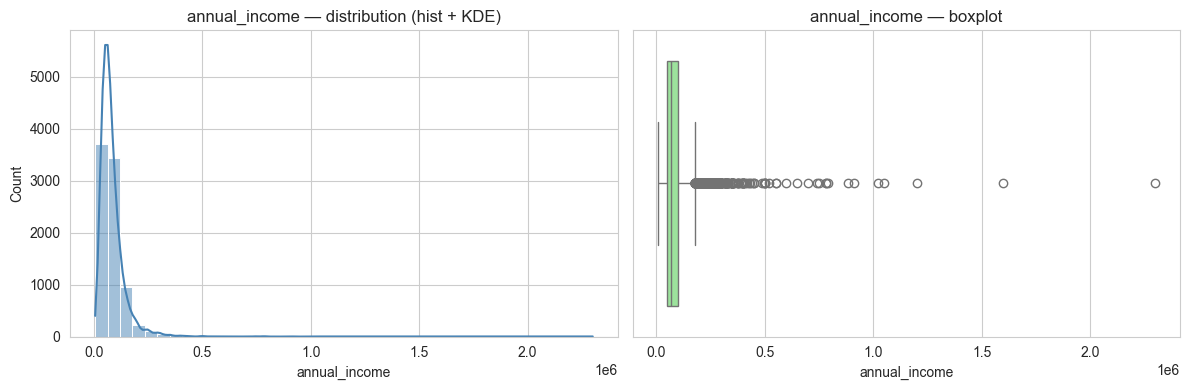

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: debt_to_income
Summary statistics:
count    8505.0000
mean       17.3394
std         8.7568
min         0.0000
25%        10.7200
50%        16.7900
75%        23.3800
max        39.9900
Name: debt_to_income, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 0.254


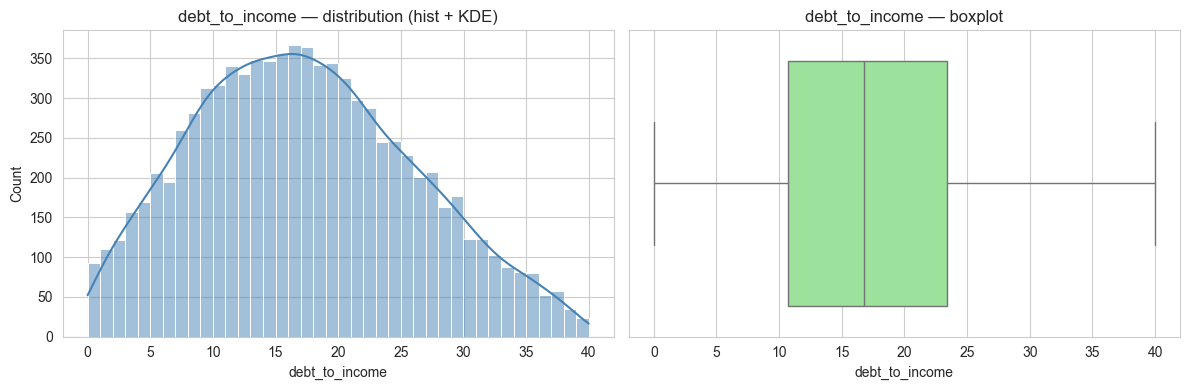

Interpretation:
- Mean and median are similar -> distribution roughly symmetric.
- Distribution approximately symmetric (low skew).

Column: delinq_2y
Summary statistics:
count    8505.0000
mean        0.2167
std         0.6926
min         0.0000
25%         0.0000
50%         0.0000
75%         0.0000
max        13.0000
Name: delinq_2y, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 6.062


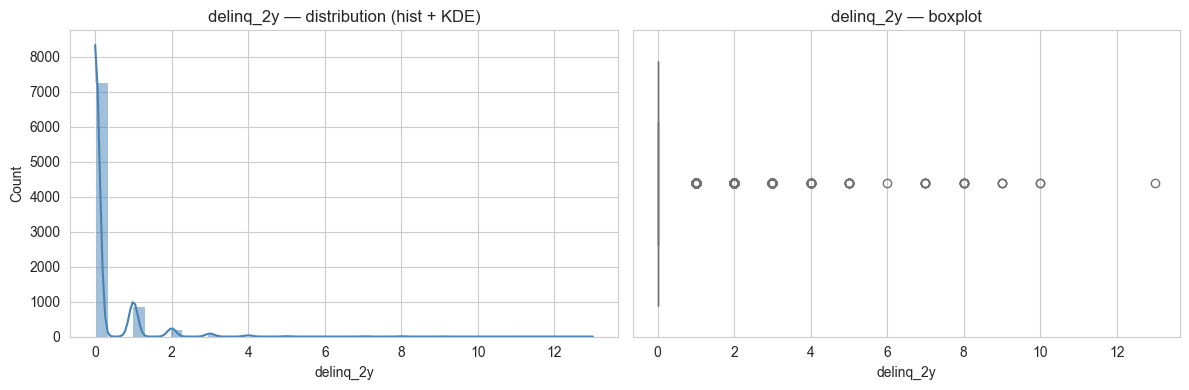

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).
- High proportion of zeros: 85.7% of borrowers have 0 delinquencies in 2y.

Column: earliest_credit_line
Summary statistics:
count    8505.0000
mean     2001.4345
std         7.7439
min      1963.0000
25%      1998.0000
50%      2003.0000
75%      2006.0000
max      2015.0000
Name: earliest_credit_line, dtype: float64
Missing: 0 (0.00%)  |  Skewness: -1.034


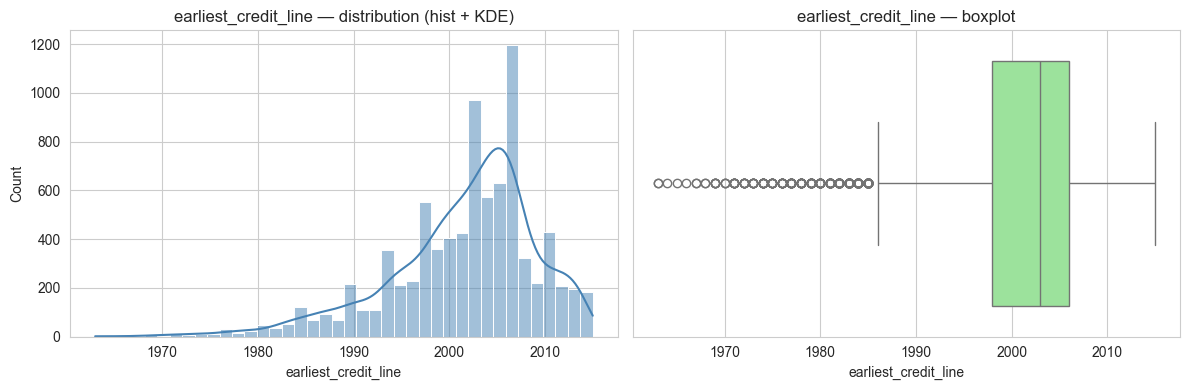

Interpretation:
- Mean and median are similar -> distribution roughly symmetric.
- Strong negative skew (long left tail).

Column: inquiries_last_12m
Summary statistics:
count    8505.0000
mean        1.9608
std         2.3646
min         0.0000
25%         0.0000
50%         1.0000
75%         3.0000
max        29.0000
Name: inquiries_last_12m, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 2.444


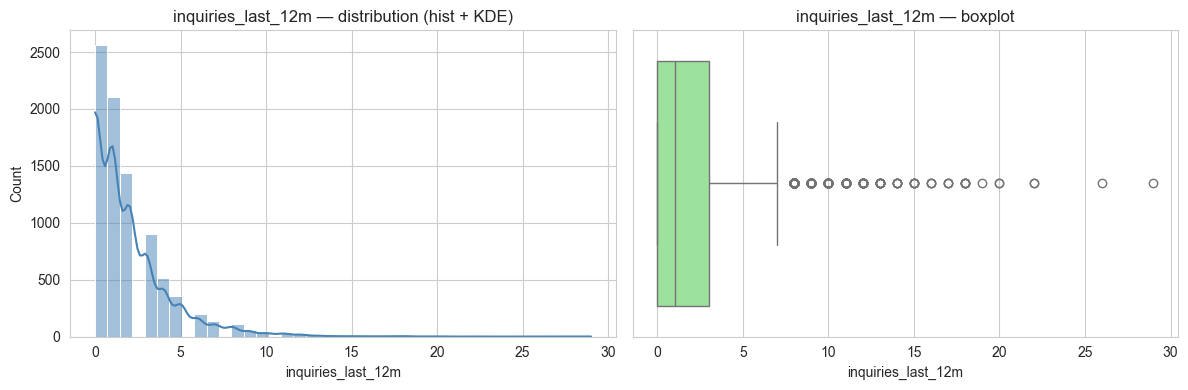

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: total_credit_lines
Summary statistics:
count    8505.0000
mean       22.6774
std        11.9260
min         2.0000
25%        14.0000
50%        21.0000
75%        29.0000
max        87.0000
Name: total_credit_lines, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 0.977


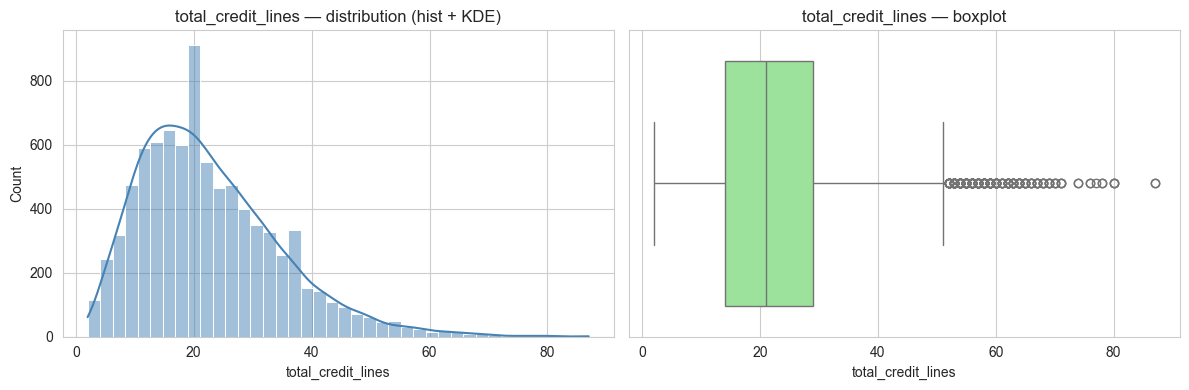

Interpretation:
- Mean and median are similar -> distribution roughly symmetric.
- Moderate skew present.

Column: open_credit_lines
Summary statistics:
count    8505.0000
mean       11.4523
std         5.9149
min         0.0000
25%         7.0000
50%        10.0000
75%        15.0000
max        51.0000
Name: open_credit_lines, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 1.170


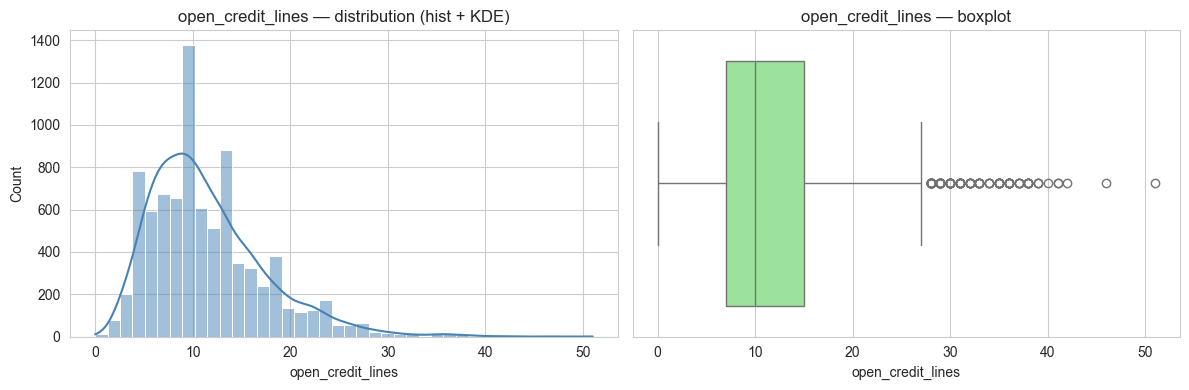

Interpretation:
- Mean and median are similar -> distribution roughly symmetric.
- Strong positive skew (long right tail).

Column: total_credit_limit
Summary statistics:
count    8.505000e+03
mean     1.759832e+05
std      1.862102e+05
min      0.000000e+00
25%      4.900000e+04
50%      1.055380e+05
75%      2.549990e+05
max      3.386034e+06
Name: total_credit_limit, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 2.941


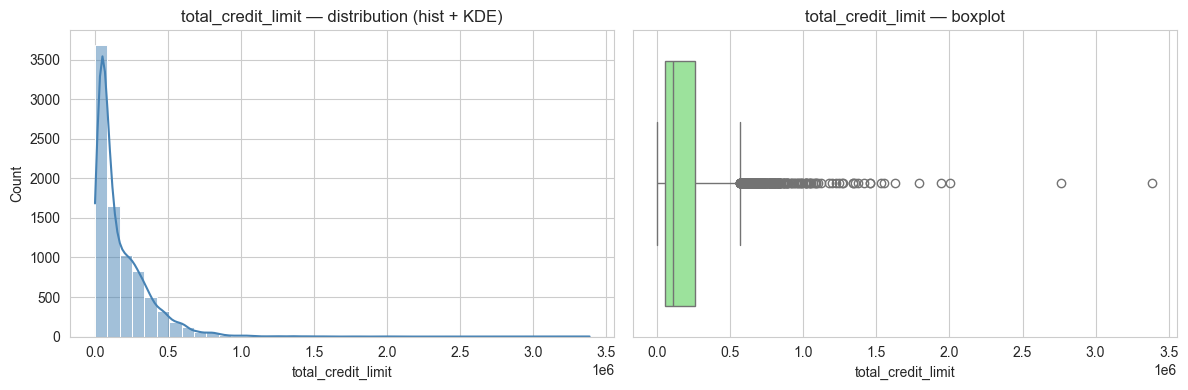

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: total_credit_utilized
Summary statistics:
count      8505.0000
mean      49921.7912
std       53885.4744
min           0.0000
25%       18703.0000
50%       35446.0000
75%       63235.0000
max      942456.0000
Name: total_credit_utilized, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 4.347


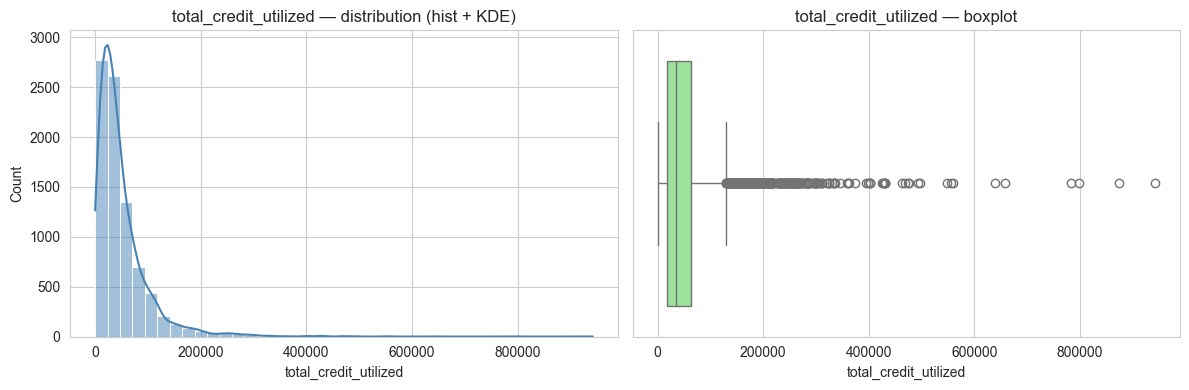

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: num_collections_last_12m
Summary statistics:
count    8505.0000
mean        0.0152
std         0.1333
min         0.0000
25%         0.0000
50%         0.0000
75%         0.0000
max         3.0000
Name: num_collections_last_12m, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 9.941


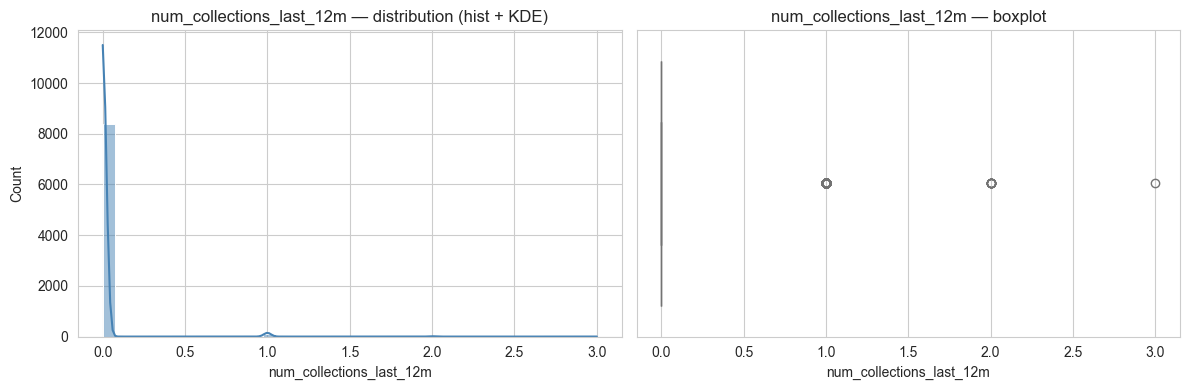

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: num_historical_failed_to_pay
Summary statistics:
count    8505.0000
mean        0.1700
std         0.7218
min         0.0000
25%         0.0000
50%         0.0000
75%         0.0000
max        52.0000
Name: num_historical_failed_to_pay, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 44.578


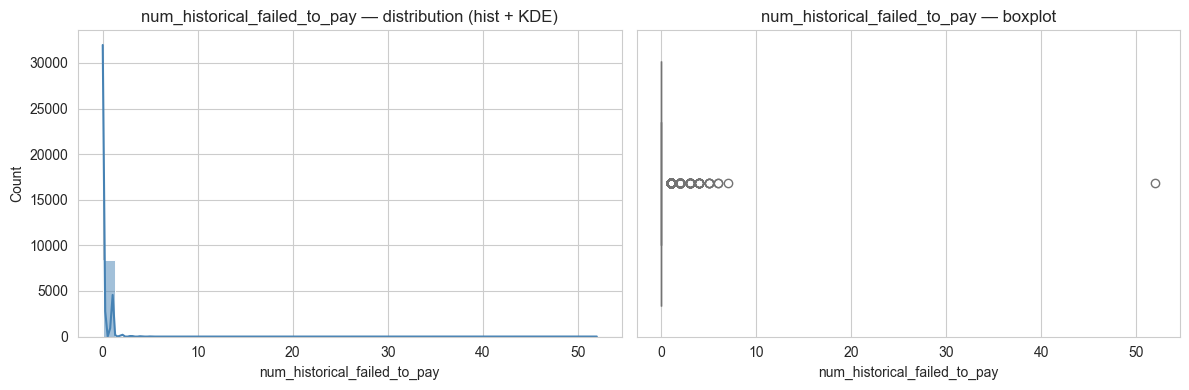

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: months_since_90d_late
Summary statistics:
count    2013.0000
mean       46.0864
std        21.6960
min         2.0000
25%        29.0000
50%        47.0000
75%        63.0000
max       128.0000
Name: months_since_90d_late, dtype: float64
Missing: 6492 (76.33%)  |  Skewness: 0.100


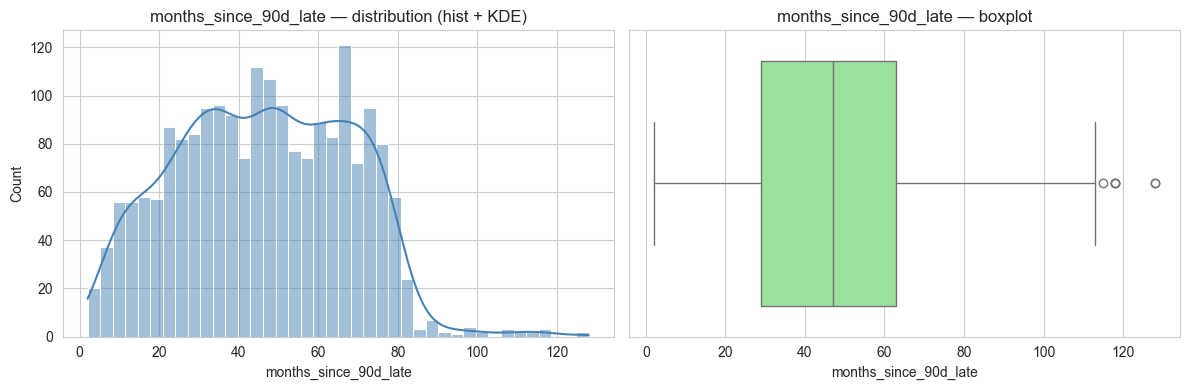

Interpretation:
- Column has 76.3% missing values which may require imputation.
- Mean and median are similar -> distribution roughly symmetric.
- Distribution approximately symmetric (low skew).

Column: current_accounts_delinq
Summary statistics:
count    8505.0000
mean        0.0001
std         0.0108
min         0.0000
25%         0.0000
50%         0.0000
75%         0.0000
max         1.0000
Name: current_accounts_delinq, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 92.206


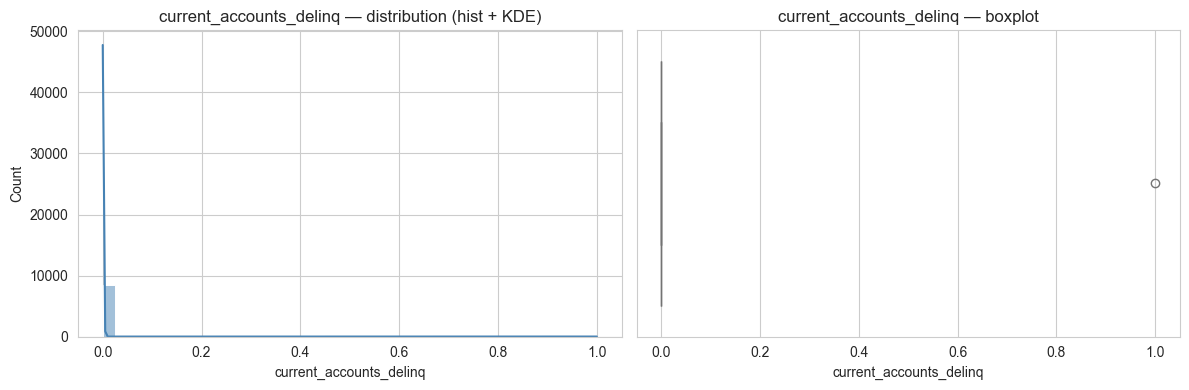

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: total_collection_amount_ever
Summary statistics:
count      8505.0000
mean        189.3914
std        2358.3508
min           0.0000
25%           0.0000
50%           0.0000
75%           0.0000
max      199308.0000
Name: total_collection_amount_ever, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 71.643


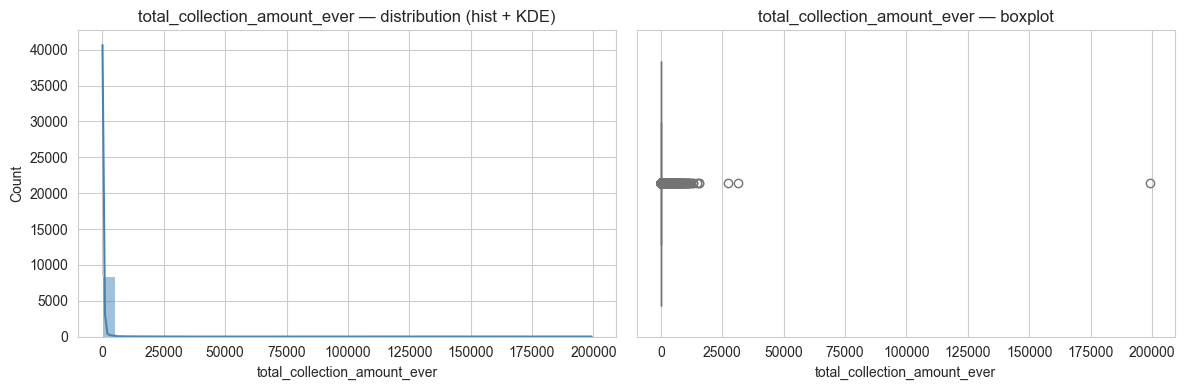

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: current_installment_accounts
Summary statistics:
count    8505.0000
mean        2.6346
std         2.9328
min         0.0000
25%         1.0000
50%         2.0000
75%         3.0000
max        35.0000
Name: current_installment_accounts, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 2.875


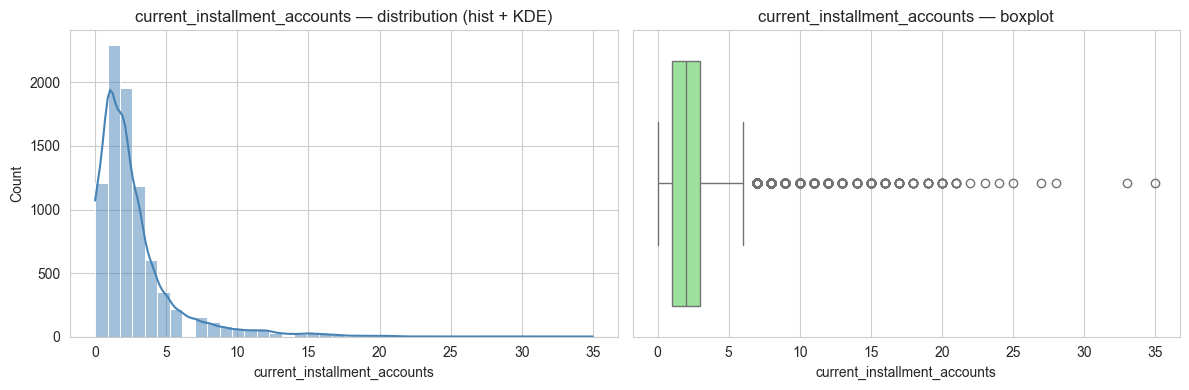

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: accounts_opened_24m
Summary statistics:
count    8505.0000
mean        4.4342
std         3.1842
min         0.0000
25%         2.0000
50%         4.0000
75%         6.0000
max        29.0000
Name: accounts_opened_24m, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 1.270


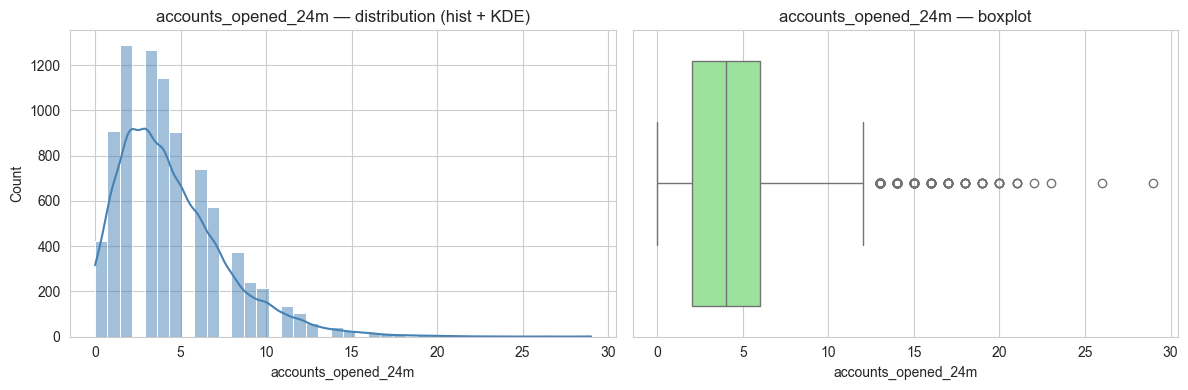

Interpretation:
- Mean and median are similar -> distribution roughly symmetric.
- Strong positive skew (long right tail).

Column: months_since_last_credit_inquiry
Summary statistics:
count    7453.0000
mean        7.3111
std         5.9719
min         0.0000
25%         2.0000
50%         6.0000
75%        11.0000
max        24.0000
Name: months_since_last_credit_inquiry, dtype: float64
Missing: 1052 (12.37%)  |  Skewness: 0.821


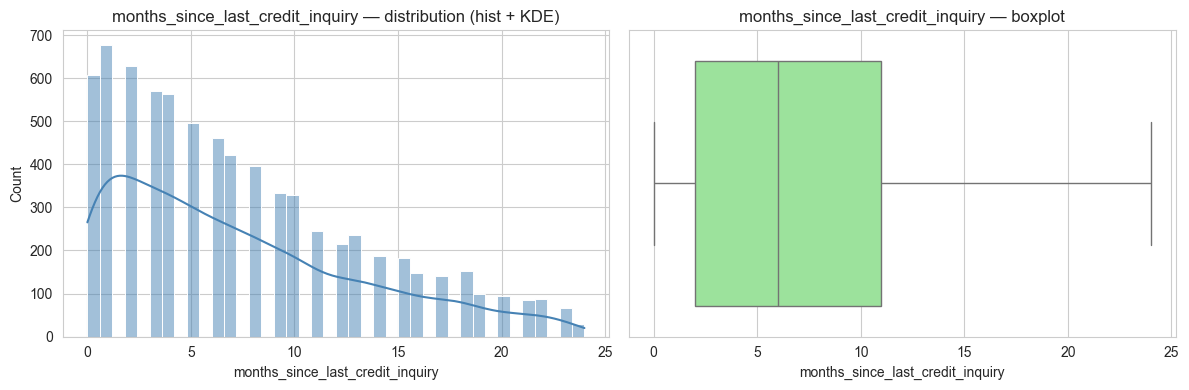

Interpretation:
- Column has 12.4% missing values which may require imputation.
- Mean and median differ substantially -> distribution is skewed.
- Moderate skew present.

Column: num_satisfactory_accounts
Summary statistics:
count    8505.0000
mean       11.4249
std         5.9047
min         0.0000
25%         7.0000
50%        10.0000
75%        14.0000
max        51.0000
Name: num_satisfactory_accounts, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 1.173


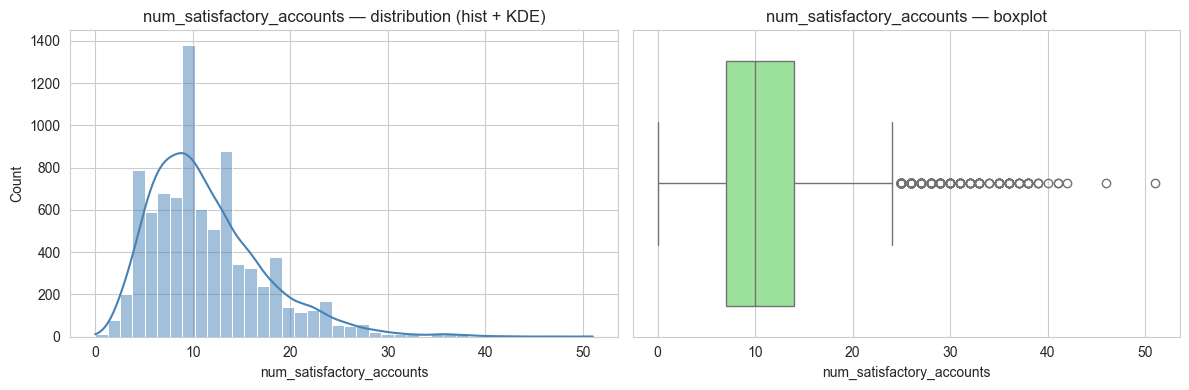

Interpretation:
- Mean and median are similar -> distribution roughly symmetric.
- Strong positive skew (long right tail).

Column: num_accounts_120d_past_due
Summary statistics:
count    8187.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: num_accounts_120d_past_due, dtype: float64
Missing: 318 (3.74%)  |  Skewness: nan


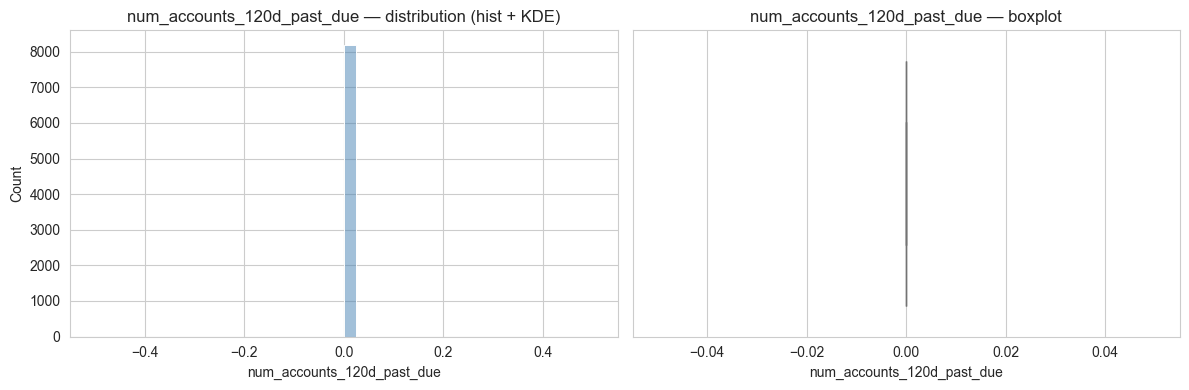

Interpretation:
- Column has 3.7% missing values which may require imputation.
- Mean and median are similar -> distribution roughly symmetric.

Column: num_accounts_30d_past_due
Summary statistics:
count    8505.0000
mean        0.0001
std         0.0108
min         0.0000
25%         0.0000
50%         0.0000
75%         0.0000
max         1.0000
Name: num_accounts_30d_past_due, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 92.206


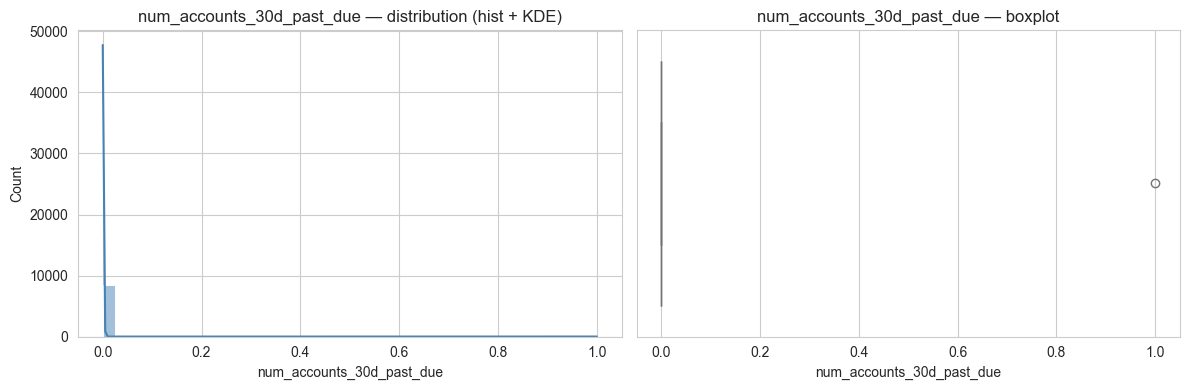

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: num_active_debit_accounts
Summary statistics:
count    8505.0000
mean        3.6717
std         2.4669
min         0.0000
25%         2.0000
50%         3.0000
75%         5.0000
max        32.0000
Name: num_active_debit_accounts, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 1.687


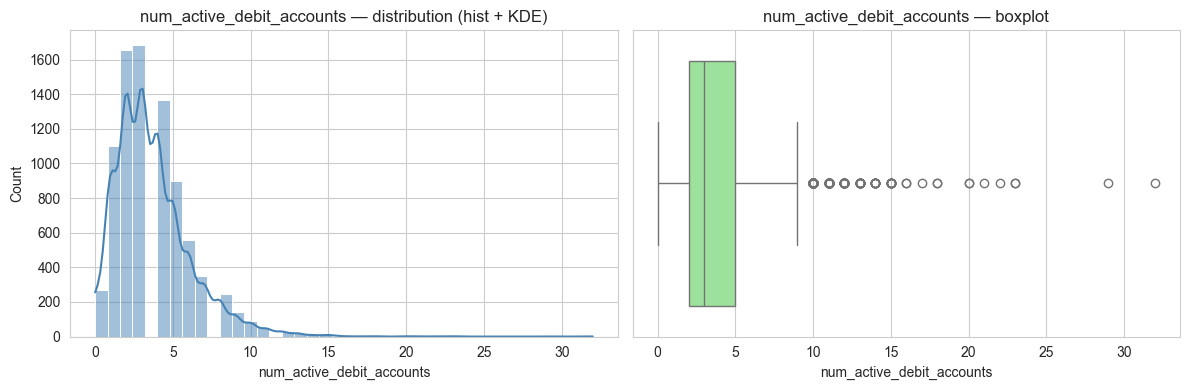

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: total_debit_limit
Summary statistics:
count      8505.0000
mean      27589.5359
std       26817.7680
min           0.0000
25%       10000.0000
50%       19600.0000
75%       36200.0000
max      386700.0000
Name: total_debit_limit, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 2.577


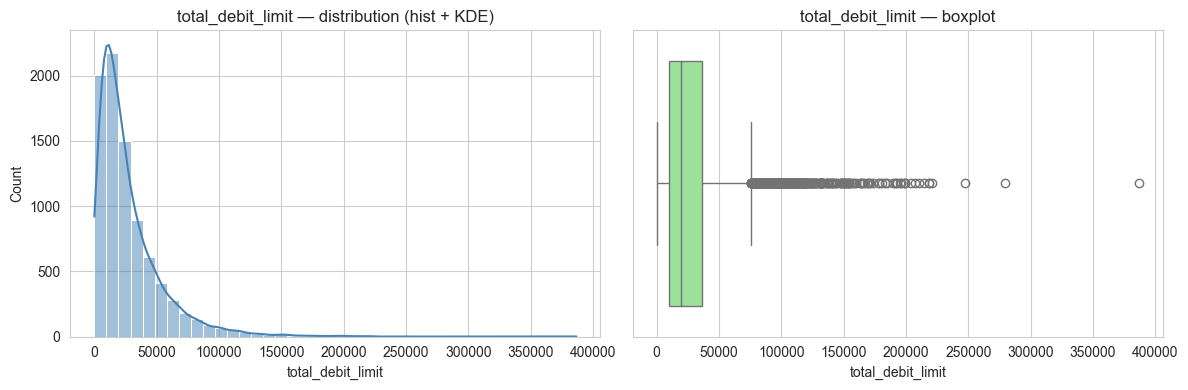

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: num_total_cc_accounts
Summary statistics:
count    8505.0000
mean       13.1385
std         7.9401
min         2.0000
25%         7.0000
50%        11.0000
75%        17.0000
max        66.0000
Name: num_total_cc_accounts, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 1.343


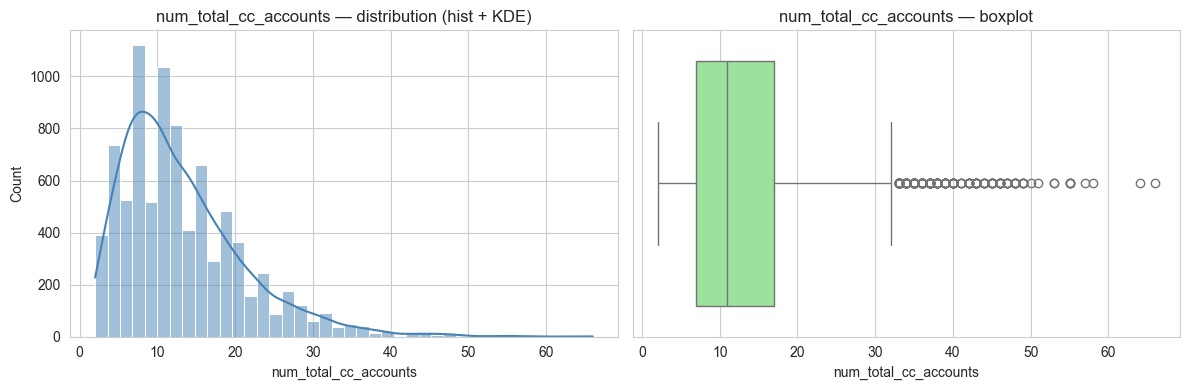

Interpretation:
- Mean and median are similar -> distribution roughly symmetric.
- Strong positive skew (long right tail).

Column: num_open_cc_accounts
Summary statistics:
count    8505.0000
mean        8.1927
std         4.9612
min         0.0000
25%         5.0000
50%         7.0000
75%        11.0000
max        46.0000
Name: num_open_cc_accounts, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 1.437


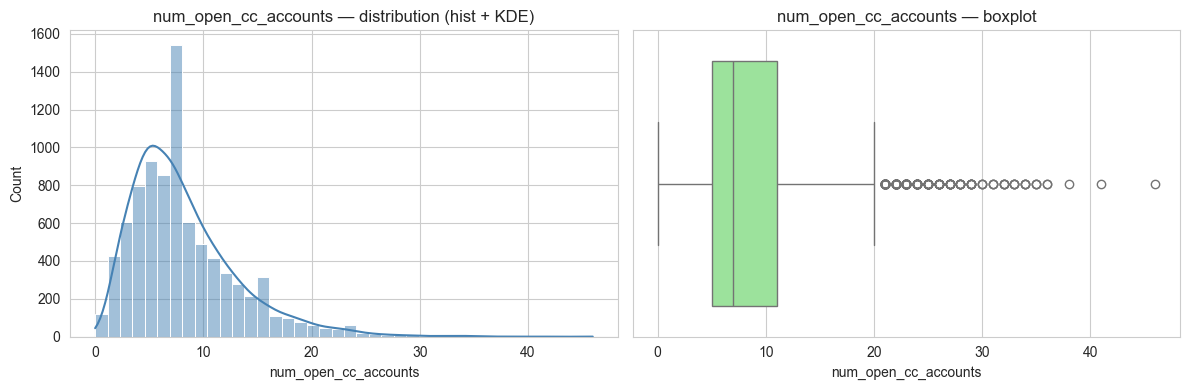

Interpretation:
- Mean and median are similar -> distribution roughly symmetric.
- Strong positive skew (long right tail).

Column: num_cc_carrying_balance
Summary statistics:
count    8505.0000
mean        5.2952
std         3.3555
min         0.0000
25%         3.0000
50%         5.0000
75%         7.0000
max        43.0000
Name: num_cc_carrying_balance, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 1.541


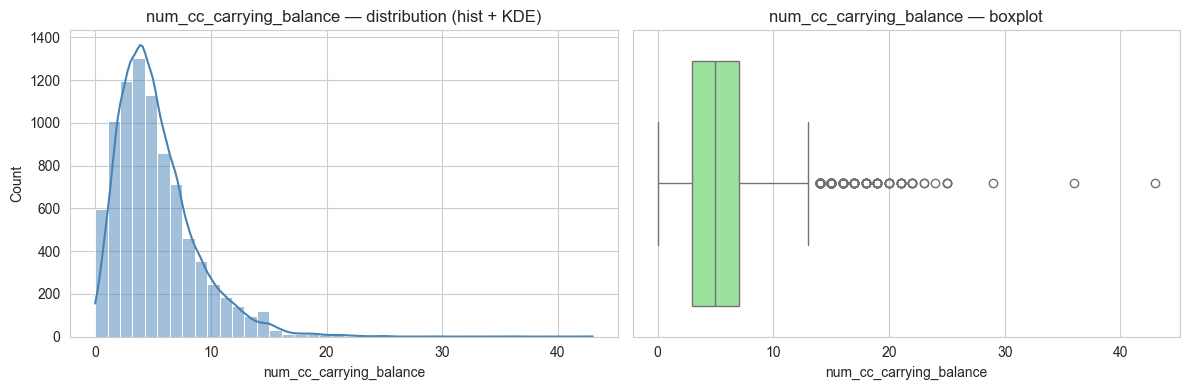

Interpretation:
- Mean and median are similar -> distribution roughly symmetric.
- Strong positive skew (long right tail).

Column: num_mort_accounts
Summary statistics:
count    8505.0000
mean        1.3102
std         1.7018
min         0.0000
25%         0.0000
50%         1.0000
75%         2.0000
max        14.0000
Name: num_mort_accounts, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 1.631


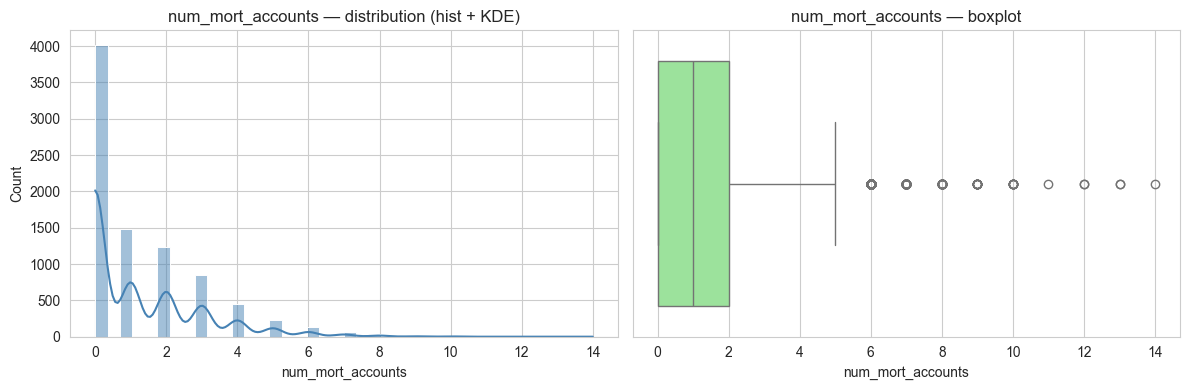

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: account_never_delinq_percent
Summary statistics:
count    8505.0000
mean       94.5508
std         9.2353
min        20.0000
25%        92.3000
50%       100.0000
75%       100.0000
max       100.0000
Name: account_never_delinq_percent, dtype: float64
Missing: 0 (0.00%)  |  Skewness: -2.531


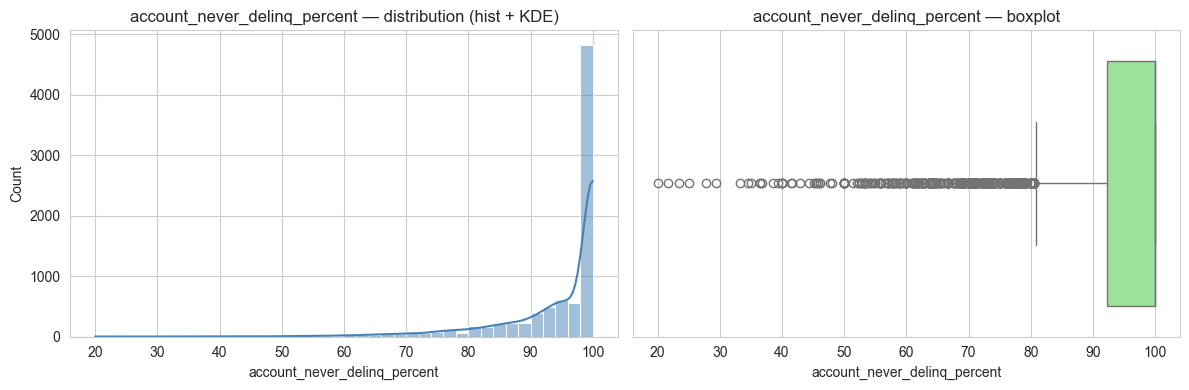

Interpretation:
- Mean and median are similar -> distribution roughly symmetric.
- Strong negative skew (long left tail).

Column: tax_liens
Summary statistics:
count    8505.0000
mean        0.0449
std         0.6326
min         0.0000
25%         0.0000
50%         0.0000
75%         0.0000
max        52.0000
Name: tax_liens, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 66.113


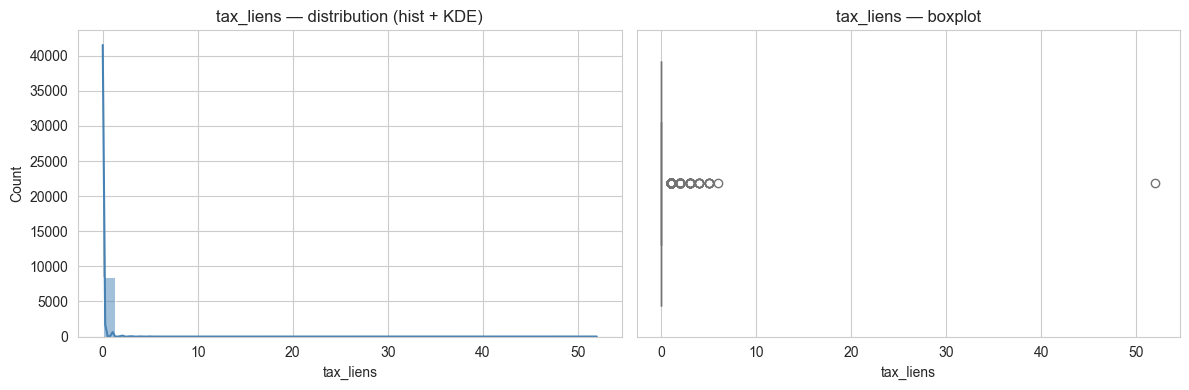

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: public_record_bankrupt
Summary statistics:
count    8505.0000
mean        0.1251
std         0.3375
min         0.0000
25%         0.0000
50%         0.0000
75%         0.0000
max         3.0000
Name: public_record_bankrupt, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 2.494


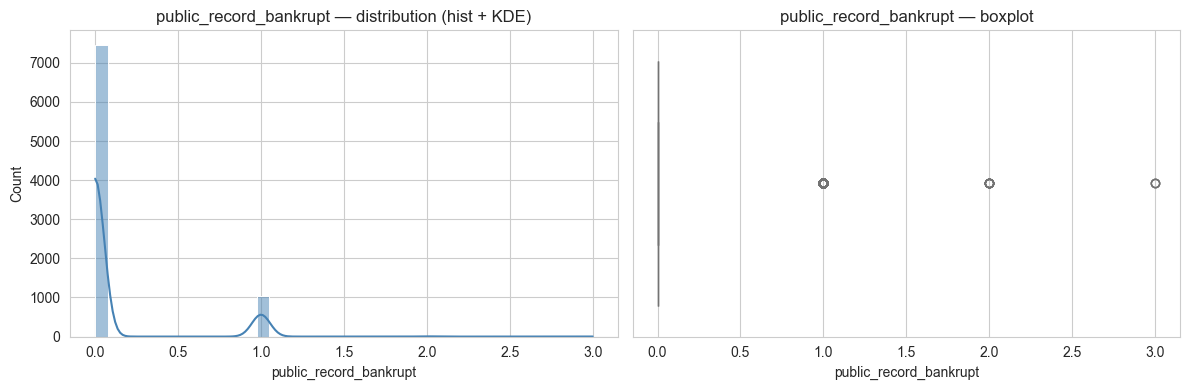

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: loan_amount
Summary statistics:
count     8505.0000
mean     15748.8448
std      10091.6239
min       1000.0000
25%       8000.0000
50%      13000.0000
75%      21000.0000
max      40000.0000
Name: loan_amount, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 0.784


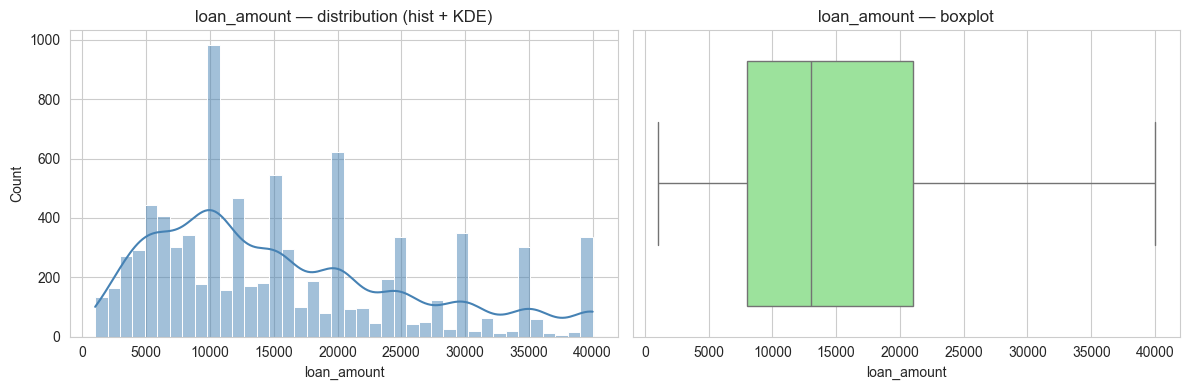

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Moderate skew present.

Column: term
Summary statistics:
count    8505.0000
mean       42.7668
std        10.7994
min        36.0000
25%        36.0000
50%        36.0000
75%        60.0000
max        60.0000
Name: term, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 0.969


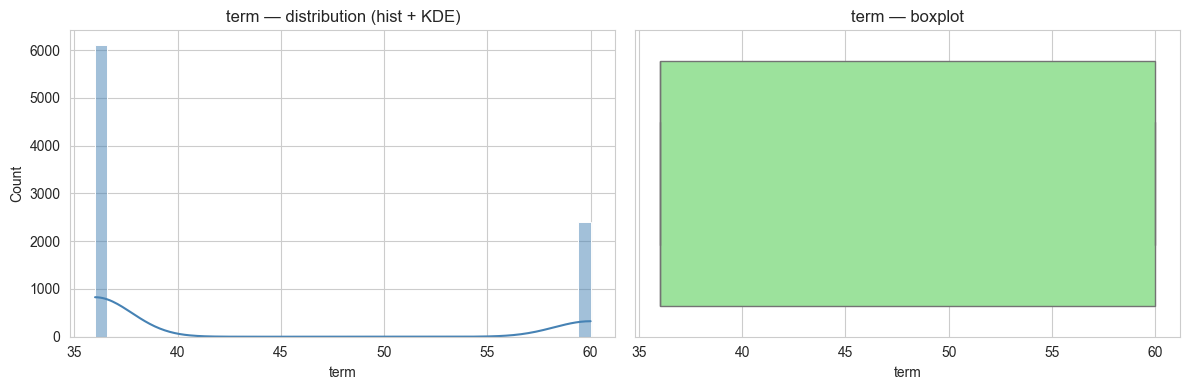

Interpretation:
- Mean and median are similar -> distribution roughly symmetric.
- Moderate skew present.

Column: interest_rate
Summary statistics:
count    8505.0000
mean       12.2992
std         4.9231
min         5.3100
25%         7.9700
50%        11.9800
75%        15.0500
max        30.9400
Name: interest_rate, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 0.863


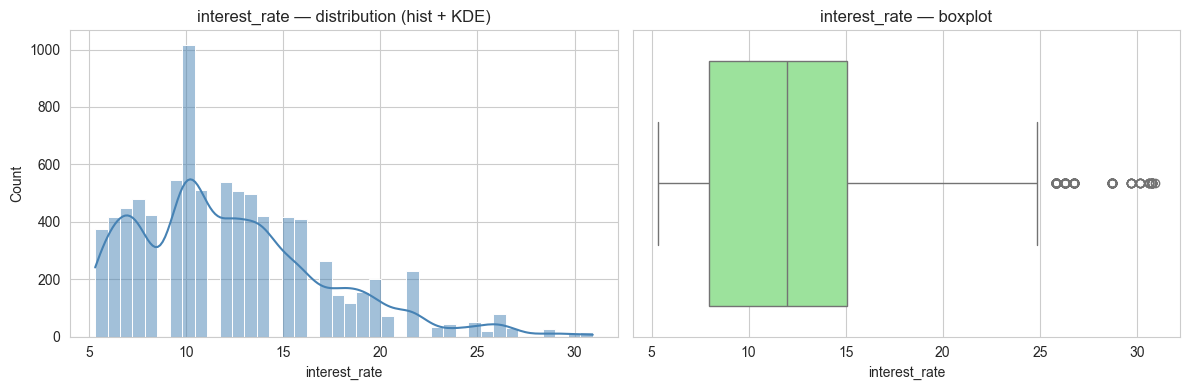

Interpretation:
- Mean and median are similar -> distribution roughly symmetric.
- Moderate skew present.
- Interest rate shows lender pricing and will be useful as a return proxy in investor analysis.

Column: installment
Summary statistics:
count    8505.0000
mean      461.1926
std       289.3447
min        30.7500
25%       246.0000
50%       379.4500
75%       626.4600
max      1503.8900
Name: installment, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 0.950


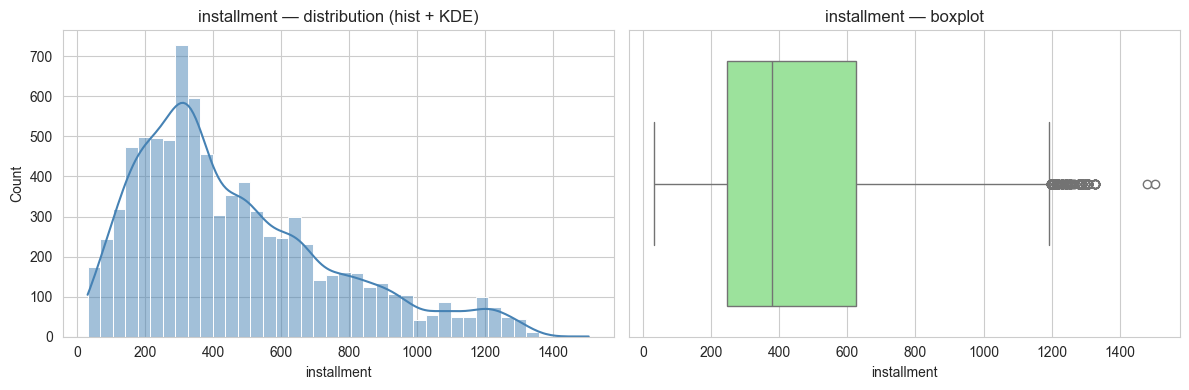

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Moderate skew present.

Column: balance
Summary statistics:
count     8505.0000
mean     13865.1116
std       9730.7259
min          0.0000
25%       6354.8000
50%      11426.6600
75%      19288.0900
max      40000.0000
Name: balance, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 0.739


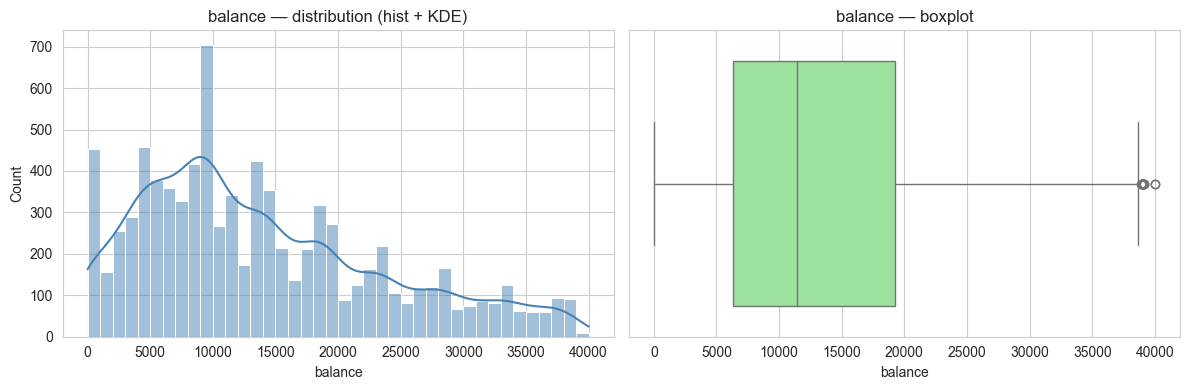

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Moderate skew present.

Column: paid_total
Summary statistics:
count     8505.0000
mean      2445.5194
std       3941.2955
min          0.0000
25%        906.8800
50%       1518.6000
75%       2561.1000
max      41630.4400
Name: paid_total, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 5.863


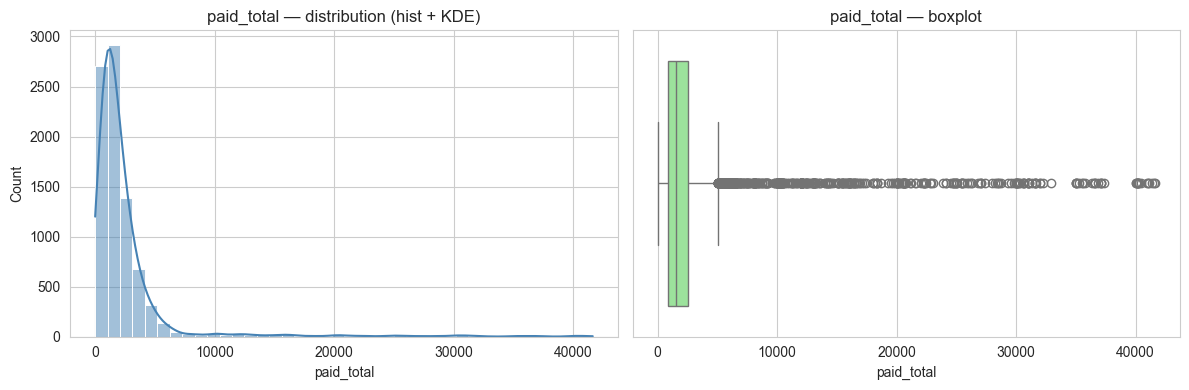

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: paid_principal
Summary statistics:
count     8505.0000
mean      1874.8354
std       3868.2154
min          0.0000
25%        574.2900
50%        970.3600
75%       1653.8800
max      40000.0000
Name: paid_principal, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 6.163


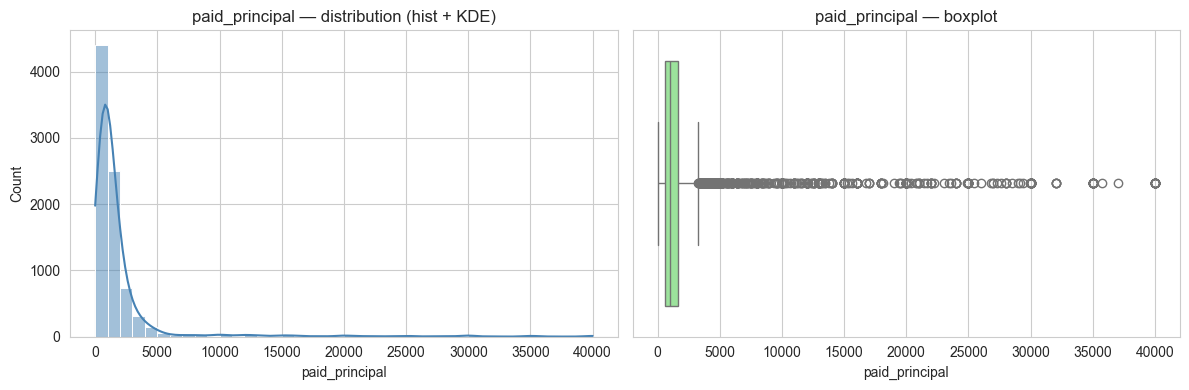

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: paid_interest
Summary statistics:
count    8505.0000
mean      570.5833
std       496.9857
min         0.0000
25%       209.6800
50%       419.3700
75%       783.8100
max      4206.1800
Name: paid_interest, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 1.652


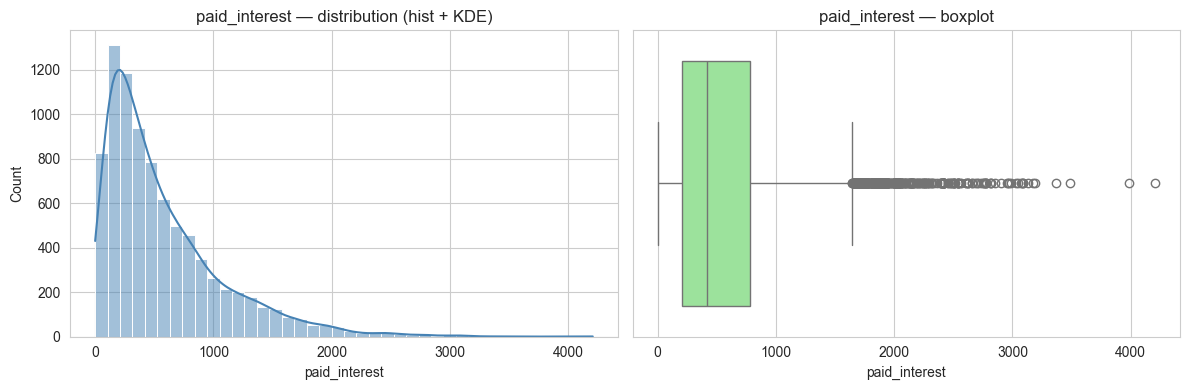

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: paid_late_fees
Summary statistics:
count    8505.0000
mean        0.1006
std         1.5952
min         0.0000
25%         0.0000
50%         0.0000
75%         0.0000
max        45.1200
Name: paid_late_fees, dtype: float64
Missing: 0 (0.00%)  |  Skewness: 18.387


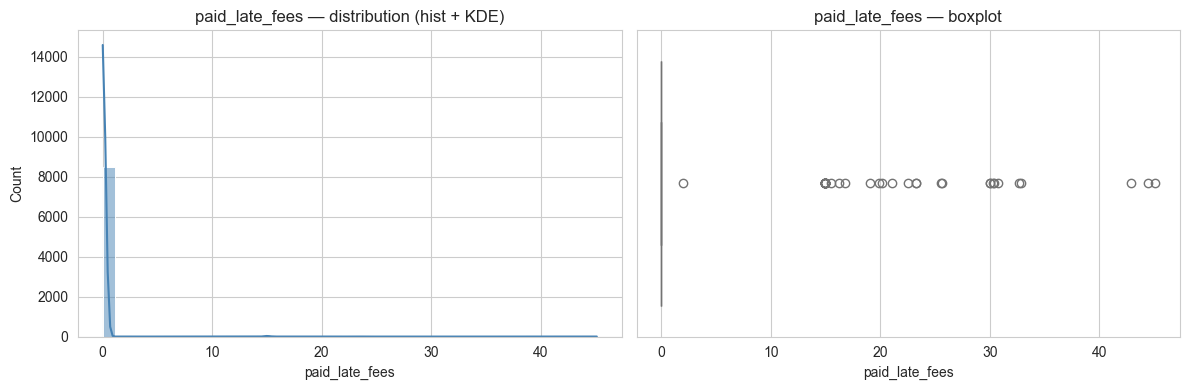

Interpretation:
- Mean and median differ substantially -> distribution is skewed.
- Strong positive skew (long right tail).

Column: year
Summary statistics:
count    8505.0
mean     2018.0
std         0.0
min      2018.0
25%      2018.0
50%      2018.0
75%      2018.0
max      2018.0
Name: year, dtype: float64
Missing: 0 (0.00%)  |  Skewness: nan


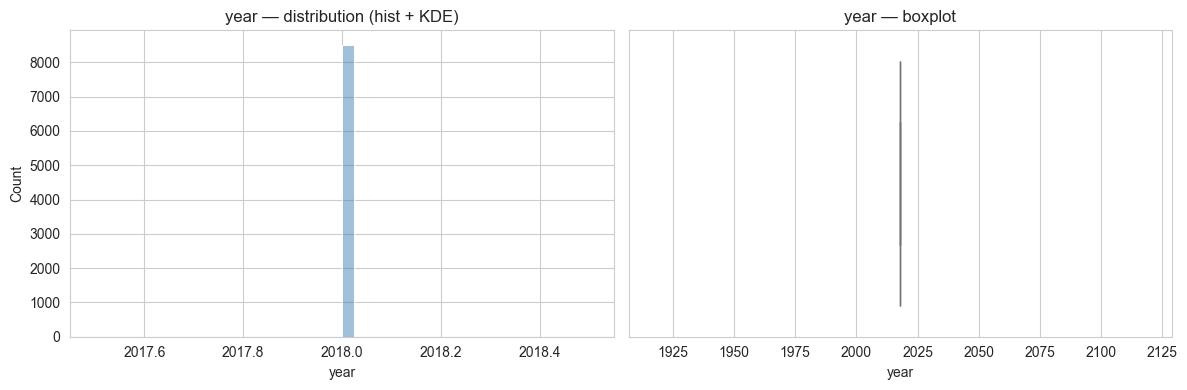

Interpretation:
- Mean and median are similar -> distribution roughly symmetric.

Column: month
Summary statistics:
count    8505.0000
mean        2.0223
std         0.8364
min         1.0000
25%         1.0000
50%         2.0000
75%         3.0000
max         3.0000
Name: month, dtype: float64
Missing: 0 (0.00%)  |  Skewness: -0.042


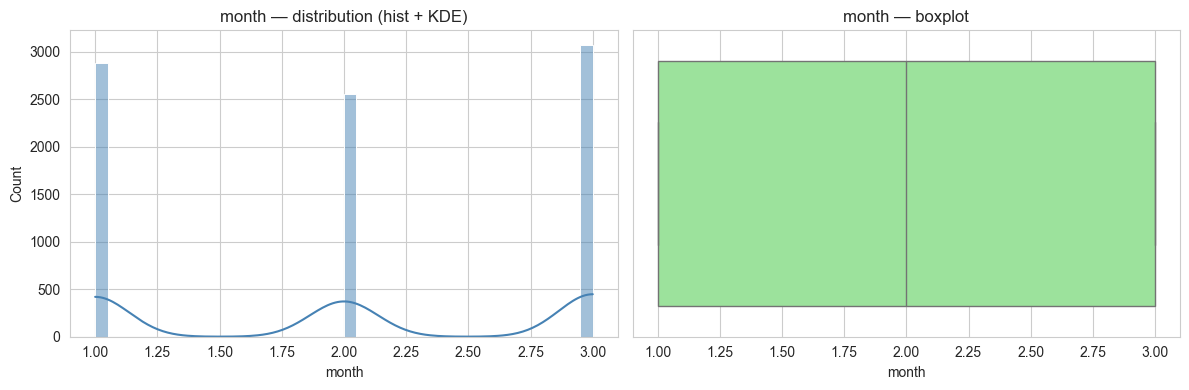

Interpretation:
- Mean and median are similar -> distribution roughly symmetric.
- Distribution approximately symmetric (low skew).


In [39]:
# Create EDA visuals for selected numeric columns
numeric_cols = df_clean.select_dtypes(include=np.number).columns.tolist()

for col in numeric_cols:
    print('\n' + '='*70)
    print(f'Column: {col}')

    # Coerce to numeric where appropriate (emp_length sometimes non-numeric)
    s = pd.to_numeric(df_clean[col], errors='coerce')

    # Basic stats
    n_total = len(s)
    n_missing = s.isna().sum()
    pct_missing = n_missing / n_total * 100 if n_total else np.nan
    desc = s.describe()
    sk = skew(s.dropna()) if s.dropna().size > 0 else np.nan

    print('Summary statistics:')
    print(desc.round(4))
    print(f'Missing: {n_missing} ({pct_missing:.2f}%)  |  Skewness: {sk:.3f}')

    # Create visualization: histogram + boxplot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    # Histogram with KDE
    sns.histplot(s.dropna(), bins=40, kde=True, ax=axes[0], color='steelblue')
    axes[0].set_title(f'{col} — distribution (hist + KDE)')

    # Boxplot (horizontal)
    sns.boxplot(x=s.dropna(), ax=axes[1], color='lightgreen')
    axes[1].set_title(f'{col} — boxplot')

    plt.tight_layout()

    plt.show()

    # Inline interpretation (automatically generated from summary stats)
    median = desc.get('50%') if '50%' in desc.index else np.nan
    mean = desc.get('mean') if 'mean' in desc.index else np.nan
    q75 = desc.get('75%') if '75%' in desc.index else np.nan
    q25 = desc.get('25%') if '25%' in desc.index else np.nan

    interpretation = []
    if pct_missing > 0:
        interpretation.append(f'Column has {pct_missing:.1f}% missing values which may require imputation.')
    if not np.isnan(mean) and not np.isnan(median):
        if abs(mean - median) / (abs(median) + 1e-9) > 0.2:
            interpretation.append('Mean and median differ substantially -> distribution is skewed.')
        else:
            interpretation.append('Mean and median are similar -> distribution roughly symmetric.')
    if not np.isnan(sk):
        if sk > 1:
            interpretation.append('Strong positive skew (long right tail).')
        elif sk < -1:
            interpretation.append('Strong negative skew (long left tail).')
        elif abs(sk) < 0.5:
            interpretation.append('Distribution approximately symmetric (low skew).')
        else:
            interpretation.append('Moderate skew present.')

    # Special notes for particular columns
    if col == 'delinq_2y':
        zeros = (s == 0).sum()
        pct_zeros = zeros / n_total * 100 if n_total else np.nan
        interpretation.append(f'High proportion of zeros: {pct_zeros:.1f}% of borrowers have 0 delinquencies in 2y.')
    if col == 'emp_length':
        interpretation.append('Employment length may be noisy; consider binning into categories (e.g., <1, 1-3, 4-10, >10 years).')
    if col == 'interest_rate':
        interpretation.append('Interest rate shows lender pricing and will be useful as a return proxy in investor analysis.')
    print('Interpretation:')
    for line in interpretation:
        print('-', line)
        

<Figure size 1200x600 with 0 Axes>

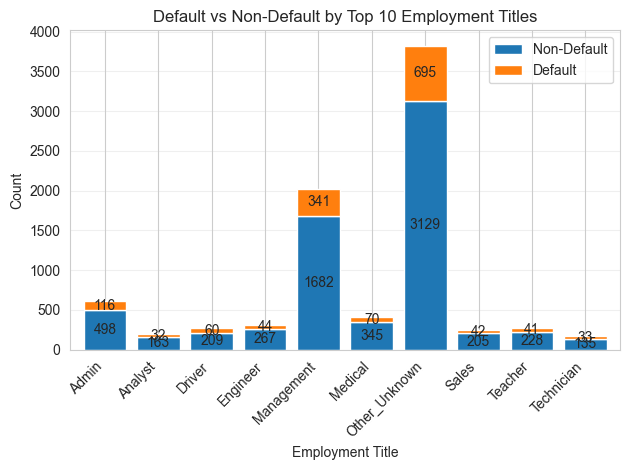


Employment Title Statistics:
loan_grade_status     0    1
emp_category                
Admin               498  116
Analyst             163   32
Driver              209   60
Engineer            267   44
Management         1682  341
Medical             345   70
Other_Unknown      3129  695
Sales               205   42
Teacher             228   41
Technician          135   33


In [40]:
# Get top 10 employment titles by frequency
top_10_titles = df_clean.groupby('emp_category').size().sort_values(ascending=False).head(10).index

# Create a dataframe with default/non-default counts for these titles
plot_data = df_clean[df_clean['emp_category'].isin(top_10_titles)].groupby(['emp_category', 'loan_grade_status']).size().unstack()

# Create the stacked bar plot
plt.figure(figsize=(12, 6))
ax = plot_data.plot(kind='bar', stacked=True, 
                    color=['tab:blue', 'tab:orange'],
                    width=0.8)

plt.title('Default vs Non-Default by Top 10 Employment Titles')
plt.xlabel('Employment Title')
plt.ylabel('Count')
plt.legend(['Non-Default', 'Default'])
plt.xticks(rotation=45, ha='right')

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='center')

plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

# Print the statistics
print("\nEmployment Title Statistics:")
print(plot_data)

<Figure size 1200x600 with 0 Axes>

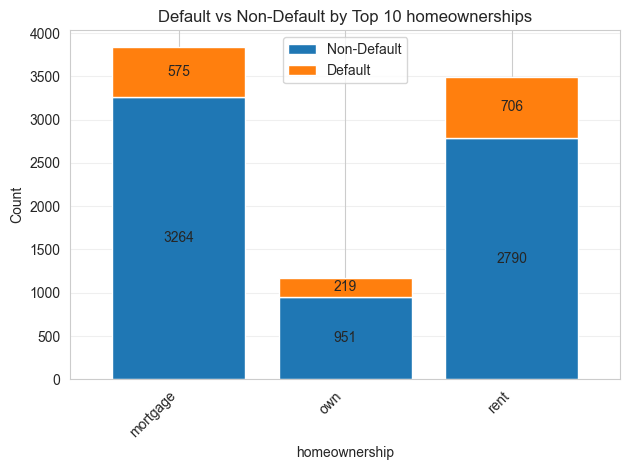

In [41]:
# Get top 10 employment titles by homeownership
top_10_titles = df_clean.groupby('homeownership').size().sort_values(ascending=False).head(10).index

# Create a dataframe with default/non-default counts for these titles
plot_data = df_clean[df_clean['homeownership'].isin(top_10_titles)].groupby(['homeownership', 'loan_grade_status']).size().unstack()

# Create the stacked bar plot
plt.figure(figsize=(12, 6))
ax = plot_data.plot(kind='bar', stacked=True, 
                    color=['tab:blue', 'tab:orange'],
                    width=0.8)

plt.title('Default vs Non-Default by Top 10 homeownerships')
plt.xlabel('homeownership')
plt.ylabel('Count')
plt.legend(['Non-Default', 'Default'])
plt.xticks(rotation=45, ha='right')

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='center')

plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

<Figure size 1200x600 with 0 Axes>

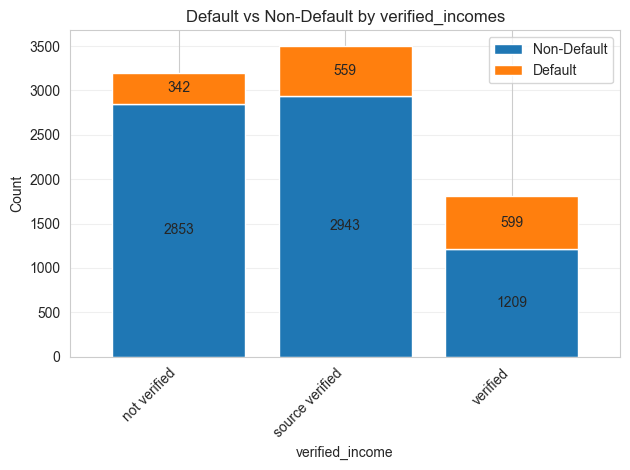

In [42]:
# Get top 10 employment titles by verified_income
top_10_titles = df_clean.groupby('verified_income').size().sort_values(ascending=False).head(10).index

# Create a dataframe with default/non-default counts for these titles
plot_data = df_clean[df_clean['verified_income'].isin(top_10_titles)].groupby(['verified_income', 'loan_grade_status']).size().unstack()

# Create the stacked bar plot
plt.figure(figsize=(12, 6))
ax = plot_data.plot(kind='bar', stacked=True, 
                    color=['tab:blue', 'tab:orange'],
                    width=0.8)

plt.title('Default vs Non-Default by verified_incomes')
plt.xlabel('verified_income')
plt.ylabel('Count')
plt.legend(['Non-Default', 'Default'])
plt.xticks(rotation=45, ha='right')

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='center')

plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

- Borrowers whose income sources has been verified get more loan and alos default the most.

<Figure size 1200x600 with 0 Axes>

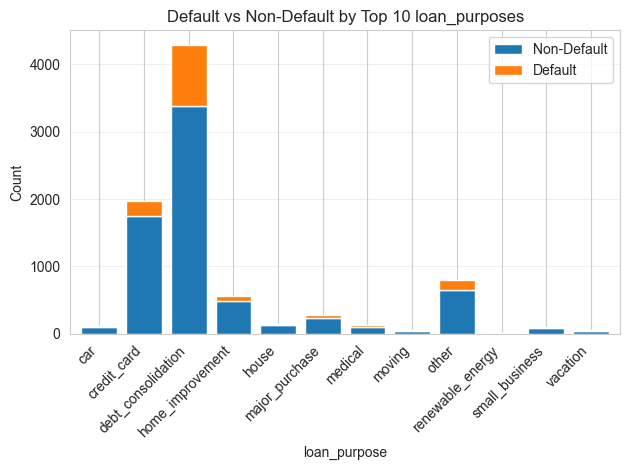

In [43]:
# Get top 10 employment titles by loan_purpose
top_10_titles = df_clean.groupby('loan_purpose').size().sort_values(ascending=False).index

# Create a dataframe with default/non-default counts for these titles
plot_data = df_clean[df_clean['loan_purpose'].isin(top_10_titles)].groupby(['loan_purpose', 'loan_grade_status']).size().unstack()

# Create the stacked bar plot
plt.figure(figsize=(12, 6))
ax = plot_data.plot(kind='bar', stacked=True, 
                    color=['tab:blue', 'tab:orange'],
                    width=0.8)

plt.title('Default vs Non-Default by Top 10 loan_purposes')
plt.xlabel('loan_purpose')
plt.ylabel('Count')
plt.legend(['Non-Default', 'Default'])
plt.xticks(rotation=45, ha='right')


plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

- Borrowers who want to consolidate their loan borrow the most in this group and alos default the most.

- They are more people in the current loan holders who are defaulting.

<Figure size 1200x600 with 0 Axes>

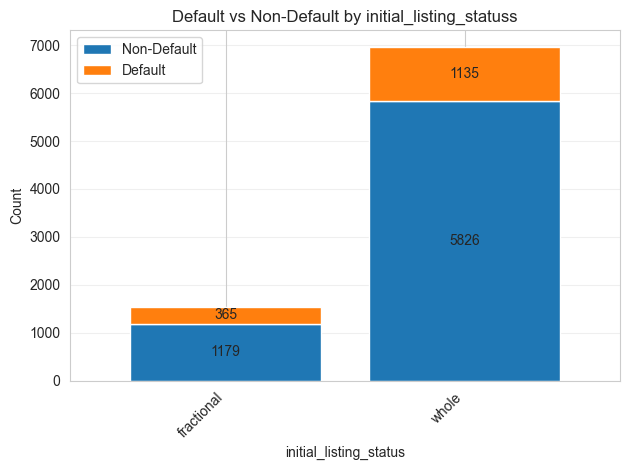

In [44]:
# Get top 10 employment titles by initial_listing_status
top_10_titles = df_clean.groupby('initial_listing_status').size().sort_values(ascending=False).head(10).index

# Create a dataframe with default/non-default counts for these titles
plot_data = df_clean[df_clean['initial_listing_status'].isin(top_10_titles)].groupby(['initial_listing_status', 'loan_grade_status']).size().unstack()

# Create the stacked bar plot
plt.figure(figsize=(12, 6))
ax = plot_data.plot(kind='bar', stacked=True, 
                    color=['tab:blue', 'tab:orange'],
                    width=0.8)

plt.title('Default vs Non-Default by initial_listing_statuss')
plt.xlabel('initial_listing_status')
plt.ylabel('Count')
plt.legend(['Non-Default', 'Default'])
plt.xticks(rotation=45, ha='right')

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='center')

plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

- Borrowers who got their loan from one lenders default the most, even though they get more loans too

<Figure size 1200x600 with 0 Axes>

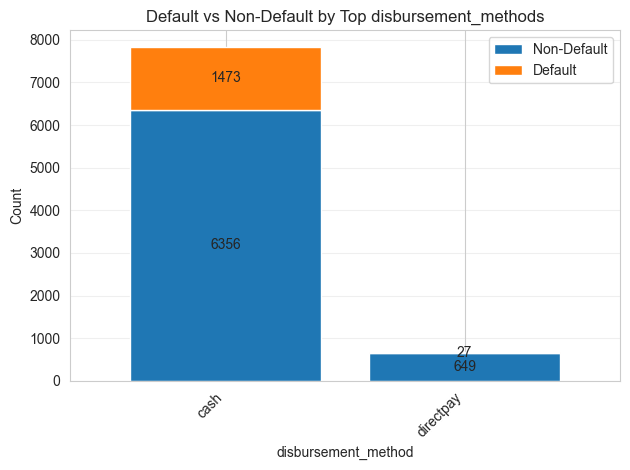

In [45]:
# Get top 10 disbursement_method by defaults status
top_10_titles = df_clean.groupby('disbursement_method').size().sort_values(ascending=False).head(10).index

# Create a dataframe with default/non-default counts for these titles
plot_data = df_clean[df_clean['disbursement_method'].isin(top_10_titles)].groupby(['disbursement_method', 'loan_grade_status']).size().unstack()

# Create the stacked bar plot
plt.figure(figsize=(12, 6))
ax = plot_data.plot(kind='bar', stacked=True, 
                    color=['tab:blue', 'tab:orange'],
                    width=0.8)

plt.title('Default vs Non-Default by Top disbursement_methods')
plt.xlabel('disbursement_method')
plt.ylabel('Count')
plt.legend(['Non-Default', 'Default'])
plt.xticks(rotation=45, ha='right')

# Add value labels on the bars
for c in ax.containers:
    ax.bar_label(c, fmt='%.0f', label_type='center')

plt.tight_layout()
plt.grid(True, alpha=0.3, axis='y')
plt.show()

In [46]:
df_clean.loan_grade_status = df_clean.loan_grade_status.astype(int)

While negative correlations were observed, features will be removed or retained based on the fisher score.

In [47]:
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

In [48]:
# Replace missing values: mean for numeric columns, mode for categorical columns

# Fill numeric columns with mean
for col in numeric_cols:
    mean_val = df_clean[col].mean()
    df_clean[col] = df_clean[col].fillna(mean_val)
    print(f"Filled {col} NaN values with mean: {mean_val:.2f}")


# Fill categorical columns with mode (or 'unknown' if no mode exists)
for col in categorical_cols:
    mode_series = df_clean[col].mode()
    if not mode_series.empty:
        mode_val = mode_series.iloc[0]  # Get the first mode value
        df_clean[col] = df_clean[col].fillna(mode_val)
        print(f"Filled {col} NaN values with mode: '{mode_val}'")
    else:
        # Fallback to 'unknown' if no mode exists
        df_clean[col] = df_clean[col].fillna('unknown')
        print(f"No mode found for {col}, filled NaN values with 'unknown'")

# Check for remaining missing values
missing_after = df_clean.isnull().sum().sum()
print(f"\nTotal missing values after imputation: {missing_after}")

# Optional: Check original df as well
missing_original = df.isnull().sum().sum()
print(f"Total missing values in original df: {missing_original}")

# Show final shape
print(f"Final dataframe shape: {df_clean.shape}")

Filled emp_length NaN values with mean: 5.88
Filled annual_income NaN values with mean: 82321.92
Filled debt_to_income NaN values with mean: 17.34
Filled delinq_2y NaN values with mean: 0.22
Filled earliest_credit_line NaN values with mean: 2001.43
Filled inquiries_last_12m NaN values with mean: 1.96
Filled total_credit_lines NaN values with mean: 22.68
Filled open_credit_lines NaN values with mean: 11.45
Filled total_credit_limit NaN values with mean: 175983.15
Filled total_credit_utilized NaN values with mean: 49921.79
Filled num_collections_last_12m NaN values with mean: 0.02
Filled num_historical_failed_to_pay NaN values with mean: 0.17
Filled months_since_90d_late NaN values with mean: 46.09
Filled current_accounts_delinq NaN values with mean: 0.00
Filled total_collection_amount_ever NaN values with mean: 189.39
Filled current_installment_accounts NaN values with mean: 2.63
Filled accounts_opened_24m NaN values with mean: 4.43
Filled months_since_last_credit_inquiry NaN values wit

In [49]:
# Detect outlier columns using IQR method
def detect_outlier_columns(df, factor=1.5):
    """
    Detect columns with outliers using IQR method.
    
    Parameters:
    df (DataFrame): Input dataframe
    factor (float): IQR multiplier for outlier detection (default 1.5)
    
    Returns:
    list: List of column names with outliers
    """
    outlier_cols = []
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    for col in numeric_cols:
        if col == 'is_default':  # Skip target column
            continue
            
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        # Check if there are outliers
        outliers = (df[col] < lower_bound) | (df[col] > upper_bound)
        if outliers.sum() > 0:
            outlier_cols.append(col)
    
    return outlier_cols

# Detect outlier columns
outlier_cols = detect_outlier_columns(df_clean)
print(f"Detected outlier columns: {outlier_cols}")

Detected outlier columns: ['annual_income', 'delinq_2y', 'earliest_credit_line', 'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines', 'total_credit_limit', 'total_credit_utilized', 'num_collections_last_12m', 'num_historical_failed_to_pay', 'months_since_90d_late', 'current_accounts_delinq', 'total_collection_amount_ever', 'current_installment_accounts', 'accounts_opened_24m', 'months_since_last_credit_inquiry', 'num_satisfactory_accounts', 'num_accounts_30d_past_due', 'num_active_debit_accounts', 'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts', 'num_cc_carrying_balance', 'num_mort_accounts', 'account_never_delinq_percent', 'tax_liens', 'public_record_bankrupt', 'interest_rate', 'installment', 'grade', 'balance', 'paid_total', 'paid_principal', 'paid_interest', 'paid_late_fees', 'loan_grade_status']


In [50]:
import numpy as np

def winsorize_outliers(df, column, lower_percentile=0.05, upper_percentile=0.95):
    """
    Winsorize outliers in a column by capping at specified percentiles.
    
    Parameters:
    df (DataFrame): Input dataframe
    column (str): Column name to process
    lower_percentile (float): Lower percentile for capping (default 0.05)
    upper_percentile (float): Upper percentile for capping (default 0.95)
    
    Returns:
    DataFrame: Dataframe with outliers winsorized
    """
    lower_bound = df_clean[column].quantile(lower_percentile)
    upper_bound = df_clean[column].quantile(upper_percentile)
    
    df[column] = np.where(df_clean[column] < lower_bound, lower_bound, 
                         np.where(df_clean[column] > upper_bound, upper_bound, df_clean[column]))
    
    print(f"Winsorized {column} at {lower_percentile*100}th and {upper_percentile*100}th percentiles")
    print(f"Lower bound: {lower_bound:.2f}, Upper bound: {upper_bound:.2f}")
    
    return df

# Example usage: Apply to detected outlier columns (excluding target column)
print("Applying winsorization to outlier columns...")
target_column = 'loan_grade_status'

for col in outlier_cols:
    if col != target_column:  # Skip the target column
        df_clean = winsorize_outliers(df_clean, col)
    else:
        print(f"Skipping target column: {col}")

print(f"\nFinal dataframe shape after winsorization: {df_clean.shape}")

Applying winsorization to outlier columns...
Winsorized annual_income at 5.0th and 95.0th percentiles
Lower bound: 28000.00, Upper bound: 180000.00
Winsorized delinq_2y at 5.0th and 95.0th percentiles
Lower bound: 0.00, Upper bound: 1.00
Winsorized earliest_credit_line at 5.0th and 95.0th percentiles
Lower bound: 1986.00, Upper bound: 2012.00
Winsorized inquiries_last_12m at 5.0th and 95.0th percentiles
Lower bound: 0.00, Upper bound: 7.00
Winsorized total_credit_lines at 5.0th and 95.0th percentiles
Lower bound: 7.00, Upper bound: 45.00
Winsorized open_credit_lines at 5.0th and 95.0th percentiles
Lower bound: 4.00, Upper bound: 23.00
Winsorized total_credit_limit at 5.0th and 95.0th percentiles
Lower bound: 17000.00, Upper bound: 527677.00
Winsorized total_credit_utilized at 5.0th and 95.0th percentiles
Lower bound: 4606.60, Upper bound: 140264.40
Winsorized num_collections_last_12m at 5.0th and 95.0th percentiles
Lower bound: 0.00, Upper bound: 0.00
Winsorized num_historical_failed_t

In [51]:
# create a dataframe for my segmenation
df_seg = df_clean.copy()

In [52]:
# drop features that can cause leakage and used for feature engineering
#for interest_rate, this could have been computed after reviewing borrowers info and computed due to this
leakage_columns = ['months_since_last_delinq','interest_rate' 'loan_status',
                       'issue_month','state','delinq_2y', 'months_since_last_delinq',
# Remove columns that will lead to leakage and columns that will not be used for analysis early to avoid leakage
    'paid_total',
    'emp_length',
    'num_accounts_120d_past_due',
     'grade', 
    'balance',
    'last_pymnt_amnt',
    'total_collection_amount_ever',
    'account_never_delinq_percent',
    'public_record_bankrupt',
    'paid_principal',
    'paid_interest',
    'paid_late_fees',
    'interest_rate',
    'loan_amount',
    'installment',
    'state',
    'num_collections_last_12m',
    # too much cardinality in subgrade, we have grade already 
    'sub_grade',
]
df_clean = df_clean.drop(columns=[col for col in leakage_columns if col in df_clean.columns])
df_clean.shape

(8505, 36)

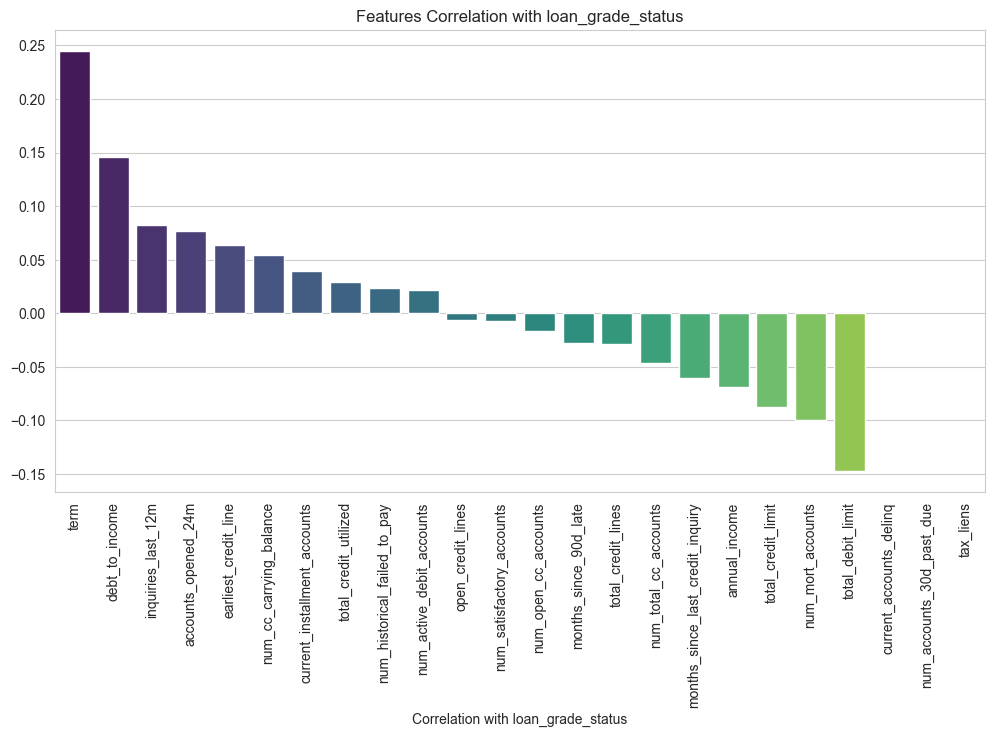

term                                0.244817
debt_to_income                      0.145849
inquiries_last_12m                  0.082474
accounts_opened_24m                 0.077036
earliest_credit_line                0.064084
num_cc_carrying_balance             0.054417
current_installment_accounts        0.039083
total_credit_utilized               0.028910
num_historical_failed_to_pay        0.023289
num_active_debit_accounts           0.021856
open_credit_lines                  -0.006810
num_satisfactory_accounts          -0.007112
num_open_cc_accounts               -0.016672
months_since_90d_late              -0.027823
total_credit_lines                 -0.028622
num_total_cc_accounts              -0.046327
months_since_last_credit_inquiry   -0.060332
annual_income                      -0.068788
total_credit_limit                 -0.087616
num_mort_accounts                  -0.100216
total_debit_limit                  -0.147337
current_accounts_delinq                  NaN
num_accoun

In [53]:
target  = 'loan_grade_status'

corr_df = df_clean.copy() 


# correlation with y
correlation_with_loan_condition = corr_df.select_dtypes(include=['int64', 'float64']).corr()[target]
sorted_correlation = correlation_with_loan_condition.drop(target).sort_values(ascending=False)

# plot
plt.figure(figsize=(12, 6))
sns.barplot(x=sorted_correlation.index, y=sorted_correlation.values, palette='viridis')
plt.xlabel('Correlation with {}'.format(target))
plt.title('Features Correlation with {}'.format(target))
plt.xticks(rotation=90)
plt.show()
print(sorted_correlation)

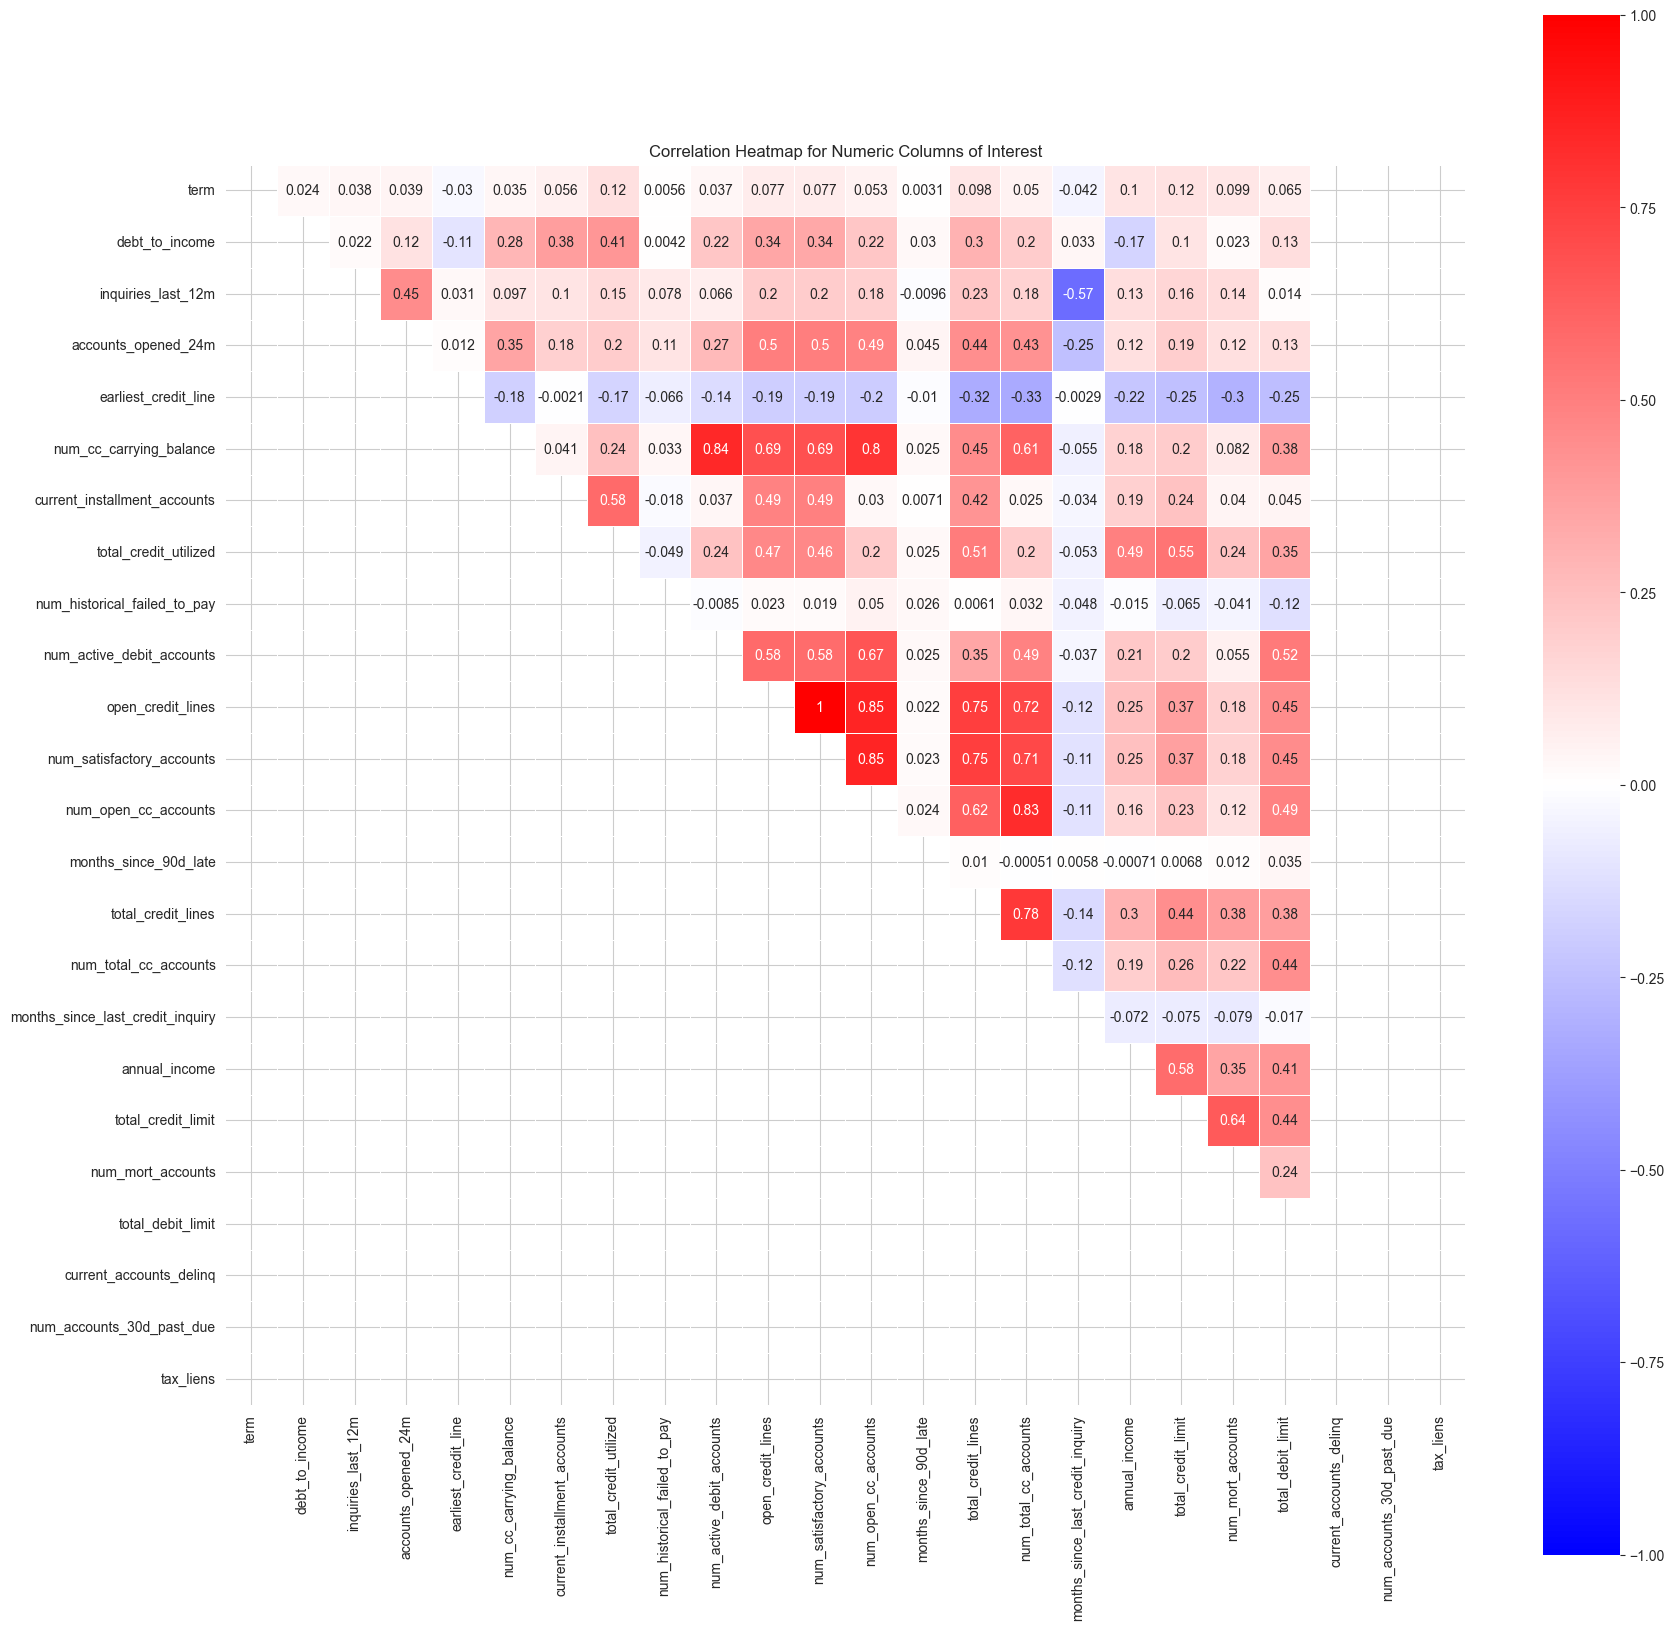

In [54]:
# Select the variables with the highest correlation with the dependent variable and explore the correlation between them
top_variables = sorted_correlation.abs().index.tolist()

plt.figure(figsize=(20, 20))
correlation_matrix = corr_df = df_clean.copy() 
correlation_matrix = correlation_matrix[top_variables].corr()
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, cmap='bwr', vmin=-1, vmax=1, square=True, linewidths=0.5, mask=mask)
plt.title('Correlation Heatmap for Numeric Columns of Interest')
plt.show()

In [55]:
correlation_matrix = corr_df[top_variables].corr()
# Identify highly correlated pairs
high_corr_pairs = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            high_corr_pairs.add((colname_i, colname_j))

# Print the highly correlated pairs
print("Highly correlated pairs (absolute correlation >= 0.8):")
for pair in high_corr_pairs:
    print(pair, correlation_matrix.loc[pair[0], pair[1]])

Highly correlated pairs (absolute correlation >= 0.8):
('num_total_cc_accounts', 'num_open_cc_accounts') 0.8270303613514729
('num_open_cc_accounts', 'open_credit_lines') 0.85375383492609
('num_satisfactory_accounts', 'open_credit_lines') 0.9993873989454798
('num_active_debit_accounts', 'num_cc_carrying_balance') 0.8403051556257798
('num_open_cc_accounts', 'num_satisfactory_accounts') 0.8532025340019836


In [56]:
# drop highly correlated columns to avoid multicollinearity
for pair in high_corr_pairs:
    col1, col2 = pair
    if col2 in df_clean.columns:
        df_clean_outliers = df_clean.drop(columns=[col2])
        print(f"Dropped column {col2} due to high correlation with {col1}")

Dropped column num_open_cc_accounts due to high correlation with num_total_cc_accounts
Dropped column open_credit_lines due to high correlation with num_open_cc_accounts
Dropped column open_credit_lines due to high correlation with num_satisfactory_accounts
Dropped column num_cc_carrying_balance due to high correlation with num_active_debit_accounts
Dropped column num_satisfactory_accounts due to high correlation with num_open_cc_accounts


In [57]:
numeric_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

In [58]:
# create a new dataframe from the clean dataframe
df_model = df_clean.copy()

In [59]:
from sklearn.metrics import make_scorer
# ### Custom Metric: Kolmogorov-Smirnov (KS) Score
#
# This is a key metric for credit 
# . It measures the maximum separation between the cumulative distribution functions (CDF) of good borrowers (class 0) and bad borrowers (class 1). A higher KS score (closer to 1) indicates better model discrimination.

# %%
def ks_score(y_true, y_pred_proba):
    """
    Calculates the Kolmogorov-Smirnov (KS) score.
    y_true: Array of true labels (0s and 1s)
    y_pred_proba: Array of predicted probabilities for the positive class (1)
    """
    # Combine true labels and predicted probabilities
    data = pd.DataFrame({'y_true': y_true, 'y_pred_proba': y_pred_proba})
    
    # Sort by predicted probability in descending order
    data = data.sort_values(by='y_pred_proba', ascending=False)
    
    # Calculate cumulative percentages
    # Ensure denominator is not zero if a class is missing (in a bad fold)
    total_good = (1 - data['y_true']).sum()
    total_bad = data['y_true'].sum()
    
    if total_good == 0 or total_bad == 0:
        return 0.0 # Cannot calculate KS if one class is missing
        
    data['cumulative_good'] = (1 - data['y_true']).cumsum() / total_good
    data['cumulative_bad'] = data['y_true'].cumsum() / total_bad
    
    # Find the maximum difference
    ks_value = (data['cumulative_bad'] - data['cumulative_good']).max()
    
    return ks_value

# Create an sklearn-compatible scorer
ks_scorer = make_scorer(ks_score, needs_proba=True)


In [60]:

# # Custom wrapper for GradientBoosting to handle sample weights
# class GradientBoostingWithSampleWeight(BaseEstimator, ClassifierMixin):
#     """Wrapper for GradientBoostingClassifier that automatically applies sample weights."""
    
#     def __init__(self, random_state=random_state, subsample=0.8, n_iter_no_change=10, validation_fraction=0.1, **kwargs):
#         self.random_state = random_state
#         self.subsample = subsample
#         self.n_iter_no_change = n_iter_no_change
#         self.validation_fraction = validation_fraction
#         self.kwargs = kwargs
#         self.model = GradientBoostingClassifier(
#             random_state=random_state,
#             subsample=subsample,
#             n_iter_no_change=n_iter_no_change,
#             validation_fraction=validation_fraction,
#             **kwargs
#         )
        
#     def fit(self, X, y):
#         sample_weights = compute_sample_weight(class_weight='balanced', y=y)
#         self.model.fit(X, y, sample_weight=sample_weights)
#         self.classes_ = self.model.classes_
#         return self
    
#     def predict(self, X):
#         return self.model.predict(X)
    
#     def predict_proba(self, X):
#         return self.model.predict_proba(X)
    
#     def get_params(self, deep=True):
#         params = {
#             'random_state': self.random_state,
#             'subsample': self.subsample,
#             'n_iter_no_change': self.n_iter_no_change,
#             'validation_fraction': self.validation_fraction
#         }
#         params.update(self.kwargs)
#         return params
    
#     def set_params(self, **params):
#         for key, value in params.items():
#             setattr(self, key, value)
#         self.model = GradientBoostingClassifier(
#             random_state=self.random_state,
#             subsample=self.subsample,
#             n_iter_no_change=self.n_iter_no_change,
#             validation_fraction=self.validation_fraction,
#             **self.kwargs
#         )
#         return self

# # Compute scale_pos_weight for XGBoost
# class_counts = y_train.value_counts()
# scale_pos_weight_value = class_counts[0] / class_counts[1]
# print(f"\nScale_pos_weight for XGBoost: {scale_pos_weight_value:.2f}")

# # 2. Define models to evaluate with proper class imbalance handling
# models = {
#     'LogisticRegression': LogisticRegression(
#         random_state=random_state, 
#         max_iter=1000, 
#         class_weight='balanced'
#     ),
#     'RandomForest': RandomForestClassifier(
#         random_state=random_state, 
#         class_weight='balanced', 
#         n_jobs=-1,
#         max_depth=10, 
#         min_samples_leaf=10
#     ),
#     'GradientBoosting': GradientBoostingWithSampleWeight(
#         random_state=random_state, 
#         subsample=0.8, 
#         n_iter_no_change=10, 
#         validation_fraction=0.1
#     ),
#     'XGBoost': XGBClassifier(
#         random_state=random_state, 
#         n_jobs=-1, 
#         eval_metric='logloss',
#         learning_rate=0.1, 
#         max_depth=4, 
#         subsample=0.8, 
#         colsample_bytree=0.8,
#         objective = 'binary:logistic',
#         use_label_encoder=False,
#         scale_pos_weight=scale_pos_weight_value
#     )
# }

# # 3. Define the pipelines
# pipelines = {}
# for name, model in models.items():
#     pipelines[name] = Pipeline([
#         ('preprocessor', preprocessor),
#         ('model', model)
#     ])


In [61]:
# 1. Define Target and Features
TARGET = 'loan_grade_status' # Change to 'loan_status' for your data
X = df_model.drop(TARGET, axis=1)
y = df_model[TARGET]

# 2. Identify feature types
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"Target: {TARGET}")
print(f"Numeric Features: {numeric_features}")
print(f"Categorical Features: {categorical_features}")
print(f"\nClass Distribution:\n{y.value_counts(normalize=True)}")

from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.base import BaseEstimator, ClassifierMixin

# Create a stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

print(f"\nTraining samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")


# 1. Create the preprocessing transformer
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

Target: loan_grade_status
Numeric Features: ['annual_income', 'debt_to_income', 'earliest_credit_line', 'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines', 'total_credit_limit', 'total_credit_utilized', 'num_historical_failed_to_pay', 'months_since_90d_late', 'current_accounts_delinq', 'current_installment_accounts', 'accounts_opened_24m', 'months_since_last_credit_inquiry', 'num_satisfactory_accounts', 'num_accounts_30d_past_due', 'num_active_debit_accounts', 'total_debit_limit', 'num_total_cc_accounts', 'num_open_cc_accounts', 'num_cc_carrying_balance', 'num_mort_accounts', 'tax_liens', 'term', 'year', 'month']
Categorical Features: ['homeownership', 'verified_income', 'loan_purpose', 'application_type', 'loan_status', 'initial_listing_status', 'disbursement_method', 'emp_category', 'region']

Class Distribution:
loan_grade_status
0    0.823633
1    0.176367
Name: proportion, dtype: float64

Training samples: 6804
Test samples: 1701


In [62]:
# Custom wrapper for GradientBoosting to handle sample weights
class GradientBoostingWithSampleWeight(BaseEstimator, ClassifierMixin):
    """Wrapper for GradientBoostingClassifier that automatically applies sample weights."""
    
    def __init__(self, random_state=random_state, subsample=0.8, n_iter_no_change=10, validation_fraction=0.1, **kwargs):
        self.random_state = random_state
        self.subsample = subsample
        self.n_iter_no_change = n_iter_no_change
        self.validation_fraction = validation_fraction
        self.kwargs = kwargs
        self.model = GradientBoostingClassifier(
            random_state=random_state,
            subsample=subsample,
            n_iter_no_change=n_iter_no_change,
            validation_fraction=validation_fraction,
            **kwargs
        )
        
    def fit(self, X, y):
        sample_weights = compute_sample_weight(class_weight='balanced', y=y)
        self.model.fit(X, y, sample_weight=sample_weights)
        self.classes_ = self.model.classes_
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)
    
    def get_params(self, deep=True):
        params = {
            'random_state': self.random_state,
            'subsample': self.subsample,
            'n_iter_no_change': self.n_iter_no_change,
            'validation_fraction': self.validation_fraction
        }
        params.update(self.kwargs)
        return params
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        self.model = GradientBoostingClassifier(
            random_state=self.random_state,
            subsample=self.subsample,
            n_iter_no_change=self.n_iter_no_change,
            validation_fraction=self.validation_fraction,
            **self.kwargs
        )
        return self

#Compute scale_pos_weight for XGBoost
class_counts = y_train.value_counts()
scale_pos_weight_value = class_counts[0] / class_counts[1]
print(f"\nScale_pos_weight for XGBoost: {scale_pos_weight_value:.2f}")


# 2. Define models to evaluate with proper class imbalance handling
models = {
    'LogisticRegression': LogisticRegression(
        random_state=random_state, 
        max_iter=1000, 
        class_weight='balanced'
    ),
    'RandomForest': RandomForestClassifier(
        random_state=random_state, 
        class_weight='balanced', 
        n_jobs=-1,
        max_depth=10, 
        min_samples_leaf=10
    ),
    'GradientBoosting': GradientBoostingWithSampleWeight(
        random_state=random_state, 
        subsample=0.8, 
        n_iter_no_change=10, 
        validation_fraction=0.1
    ),
    'XGBoost': XGBClassifier(
        random_state=random_state, 
        n_jobs=-1, 
        eval_metric='logloss',
        learning_rate=0.1, 
        max_depth=4, 
        subsample=0.8, 
        colsample_bytree=0.8,
        objective = 'binary:logistic',
        use_label_encoder=False,
        scale_pos_weight=scale_pos_weight_value
    )
}

# 3. Define the pipelines
pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])


Scale_pos_weight for XGBoost: 4.67



Fitting all 4 models on full training data...
... fitting LogisticRegression
... fitting RandomForest
... fitting GradientBoosting
... fitting XGBoost
All models fitted.

--- Detailed Analysis for: LogisticRegression ---

--- 1. Generalization Check ---


,Metric,Training Set,Test Set,Drop-off
0,KS Score,0.5184,0.4738,0.0446
1,AUC,0.8354,0.8027,0.0327



--- 2. Confusion Matrix & Classification Report (Test Set) ---
              precision    recall  f1-score   support

    Paid (0)       0.93      0.73      0.82      1401
 Default (1)       0.37      0.74      0.49       300

    accuracy                           0.73      1701
   macro avg       0.65      0.73      0.65      1701
weighted avg       0.83      0.73      0.76      1701



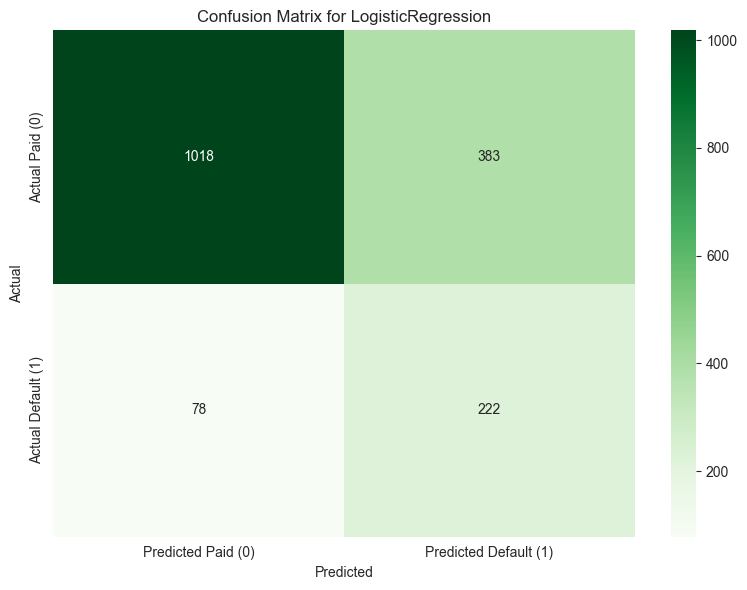


--- Detailed Analysis for: RandomForest ---

--- 1. Generalization Check ---


,Metric,Training Set,Test Set,Drop-off
0,KS Score,0.7389,0.4633,0.2756
1,AUC,0.9406,0.7959,0.1447



--- 2. Confusion Matrix & Classification Report (Test Set) ---
              precision    recall  f1-score   support

    Paid (0)       0.91      0.84      0.87      1401
 Default (1)       0.44      0.60      0.50       300

    accuracy                           0.79      1701
   macro avg       0.67      0.72      0.69      1701
weighted avg       0.82      0.79      0.80      1701



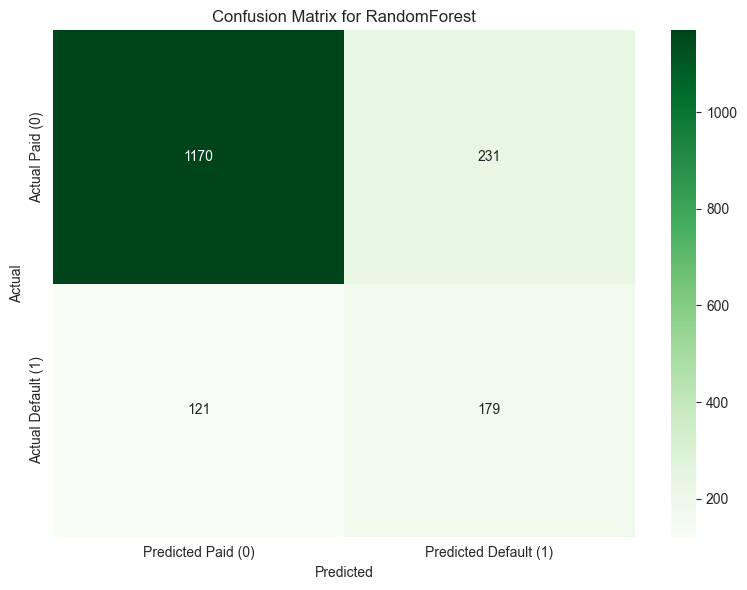


--- Detailed Analysis for: GradientBoosting ---

--- 1. Generalization Check ---


,Metric,Training Set,Test Set,Drop-off
0,KS Score,0.6001,0.4873,0.1128
1,AUC,0.8771,0.8101,0.0670



--- 2. Confusion Matrix & Classification Report (Test Set) ---
              precision    recall  f1-score   support

    Paid (0)       0.93      0.75      0.83      1401
 Default (1)       0.38      0.72      0.50       300

    accuracy                           0.74      1701
   macro avg       0.65      0.74      0.66      1701
weighted avg       0.83      0.74      0.77      1701



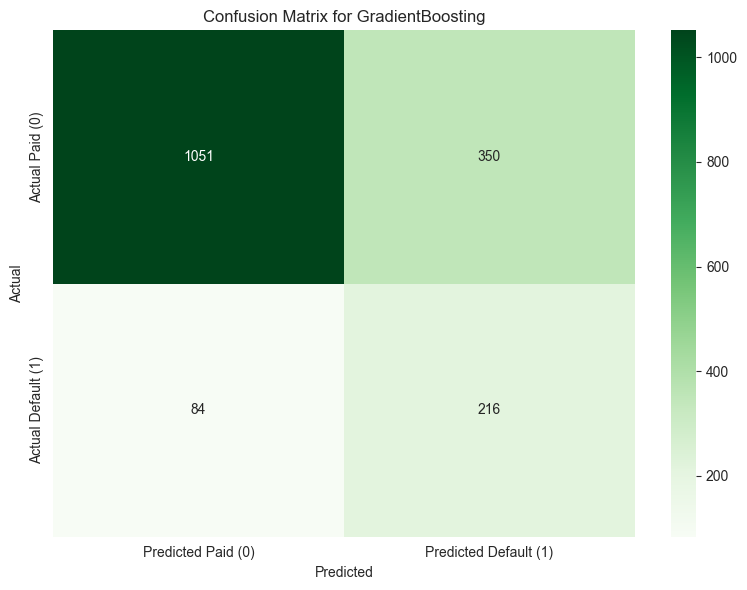


--- Detailed Analysis for: XGBoost ---

--- 1. Generalization Check ---


,Metric,Training Set,Test Set,Drop-off
0,KS Score,0.7042,0.4807,0.2235
1,AUC,0.9232,0.8051,0.1181



--- 2. Confusion Matrix & Classification Report (Test Set) ---
              precision    recall  f1-score   support

    Paid (0)       0.92      0.77      0.84      1401
 Default (1)       0.39      0.70      0.50       300

    accuracy                           0.75      1701
   macro avg       0.66      0.73      0.67      1701
weighted avg       0.83      0.75      0.78      1701



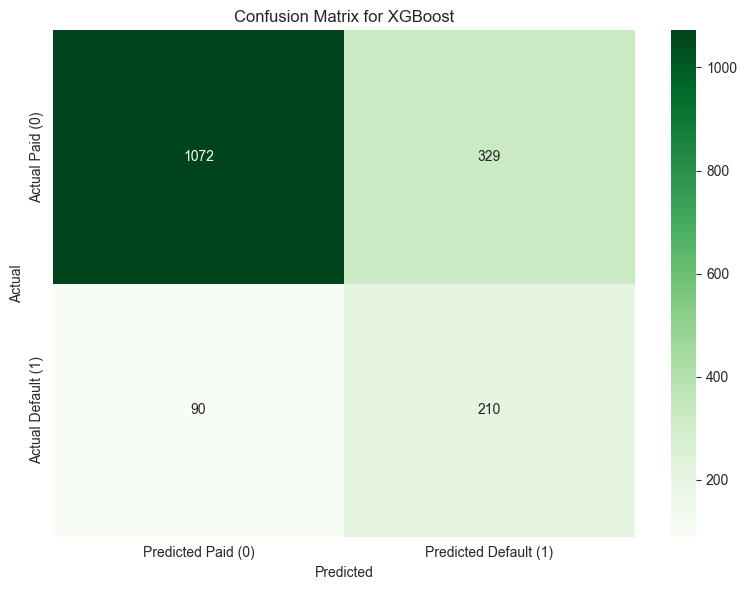

In [63]:
# 5. Fit all models on the full training data
print("\nFitting all 4 models on full training data...")
fitted_pipelines = {}
for name, pipe in pipelines.items():
    print(f"... fitting {name}")
    pipe.fit(X_train, y_train)
    fitted_pipelines[name] = pipe
print("All models fitted.")

# 6. Loop through and analyze each fitted model
test_set_scores = []

for name, pipe in fitted_pipelines.items():
    print("\n" + "="*80)
    print(f"--- Detailed Analysis for: {name} ---")
    print("="*80)
    
    print("\n--- 1. Generalization Check ---")
    pd_scores_train = pipe.predict_proba(X_train)[:, 1]
    pd_scores_test = pipe.predict_proba(X_test)[:, 1]

    train_ks = ks_score(y_train, pd_scores_train)
    train_auc = roc_auc_score(y_train, pd_scores_train)
    train_pr_auc = average_precision_score(y_train, pd_scores_train)

    test_ks = ks_score(y_test, pd_scores_test)
    test_auc = roc_auc_score(y_test, pd_scores_test)
    test_pr_auc = average_precision_score(y_test, pd_scores_test)

    generalization_df = pd.DataFrame({
        'Metric': ['KS Score', 'AUC'],
        'Training Set': [train_ks, train_auc],
        'Test Set': [test_ks, test_auc]
    })
    generalization_df['Drop-off'] = generalization_df['Training Set'] - generalization_df['Test Set']
    display(generalization_df.round(4))
    
    test_set_scores.append({
        'Model': name,
        'AUC_Test': test_auc,
        'KS_Score_Test': test_ks
    })
    
    print("\n--- 2. Confusion Matrix & Classification Report (Test Set) ---")
    y_pred_test = pipe.predict(X_test)
    print(classification_report(y_test, y_pred_test, target_names=['Paid (0)', 'Default (1)']))

    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Predicted Paid (0)', 'Predicted Default (1)'],
                yticklabels=['Actual Paid (0)', 'Actual Default (1)'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix for {name}')
    plt.tight_layout()
    plt.show()

In [64]:
# 8. Generalization Assessment (Rule-Based)
def assess_generalization(train_auc, test_auc, threshold_moderate=0.05, threshold_severe=0.10):
    """
        
    Parameters:
    - train_auc: AUC on training set
    - test_auc: AUC on test set
    - threshold_moderate: Threshold for moderate overfitting (default 5%)
    - threshold_severe: Threshold for severe overfitting (default 10%)
    
    Returns:
    - assessment: String describing generalization status
    - auc_drop: Numeric drop in AUC from train to test
    """
    auc_drop = train_auc - test_auc
    
    if auc_drop < 0:
        return "Test Better Than Train (Unusual)", auc_drop
    elif auc_drop <= threshold_moderate:
        return "Good Generalization", auc_drop
    elif auc_drop <= threshold_severe:
        return "Moderate Overfitting", auc_drop
    else:
        return "Severe Overfitting", auc_drop

print("\n" + "="*80)
print("GENERALIZATION ASSESSMENT SUMMARY")
print("="*80)

generalization_results = []

for name, pipe in fitted_pipelines.items():
    y_pred_train = pipe.predict_proba(X_train)[:, 1]
    y_pred_test = pipe.predict_proba(X_test)[:, 1]
    
    train_auc = roc_auc_score(y_train, y_pred_train)
    test_auc = roc_auc_score(y_test, y_pred_test)
    
    assessment, auc_drop = assess_generalization(train_auc, test_auc)
    
    generalization_results.append({
        "Model": name,
        "Train_AUC": round(train_auc, 4),
        "Test_AUC": round(test_auc, 4),
        "AUC_Drop": round(auc_drop, 4),
        "Drop_%": round(auc_drop * 100, 2),
        "Assessment": assessment
    })
    
    print(f"\n{name}:")
    print(f"  Train AUC: {train_auc:.4f}")
    print(f"  Test AUC:  {test_auc:.4f}")
    print(f"  Drop:      {auc_drop:.4f} ({auc_drop*100:.2f}%)")
    print(f"  → {assessment}")

generalization_summary = pd.DataFrame(generalization_results)
generalization_summary = generalization_summary.sort_values(
    by=["AUC_Drop", "Test_AUC"], ascending=[True, False]
).reset_index(drop=True)

print("\n" + "="*80)
print("RANKED BY GENERALIZATION (Best to Worst)")
print("="*80)
display(generalization_summary.T)

best_model = generalization_summary.iloc[0]
print(f"\n Best Generalizing Model: {best_model['Model']}")
print(f"   Test AUC: {best_model['Test_AUC']}, Drop: {best_model['AUC_Drop']} ({best_model['Drop_%']}%)")

good_models = generalization_summary[generalization_summary["Assessment"] == "Good Generalization"]
if len(good_models) > 0:
    print(f"\n Models with Good Generalization (≤5% drop):")
    for idx, row in good_models.iterrows():
        print(f"   • {row['Model']}: Test AUC={row['Test_AUC']}, Drop={row['Drop_%']}%")
else:
    print("\n No models achieved 'Good Generalization' (all have >5% AUC drop)")


GENERALIZATION ASSESSMENT SUMMARY

LogisticRegression:
  Train AUC: 0.8354
  Test AUC:  0.8027
  Drop:      0.0327 (3.27%)
  → Good Generalization

RandomForest:
  Train AUC: 0.9406
  Test AUC:  0.7959
  Drop:      0.1447 (14.47%)
  → Severe Overfitting

GradientBoosting:
  Train AUC: 0.8771
  Test AUC:  0.8101
  Drop:      0.0670 (6.70%)
  → Moderate Overfitting

XGBoost:
  Train AUC: 0.9232
  Test AUC:  0.8051
  Drop:      0.1181 (11.81%)
  → Severe Overfitting

RANKED BY GENERALIZATION (Best to Worst)


,0,1,2,3
Model,LogisticRegression,GradientBoosting,XGBoost,RandomForest
Train_AUC,0.8354,0.8771,0.9232,0.9406
Test_AUC,0.8027,0.8101,0.8051,0.7959
AUC_Drop,0.0327,0.067,0.1181,0.1447
Drop_%,3.27,6.7,11.81,14.47
Assessment,Good Generalization,Moderate Overfitting,Severe Overfitting,Severe Overfitting



 Best Generalizing Model: LogisticRegression
   Test AUC: 0.8027, Drop: 0.0327 (3.27%)

 Models with Good Generalization (≤5% drop):
   • LogisticRegression: Test AUC=0.8027, Drop=3.27%


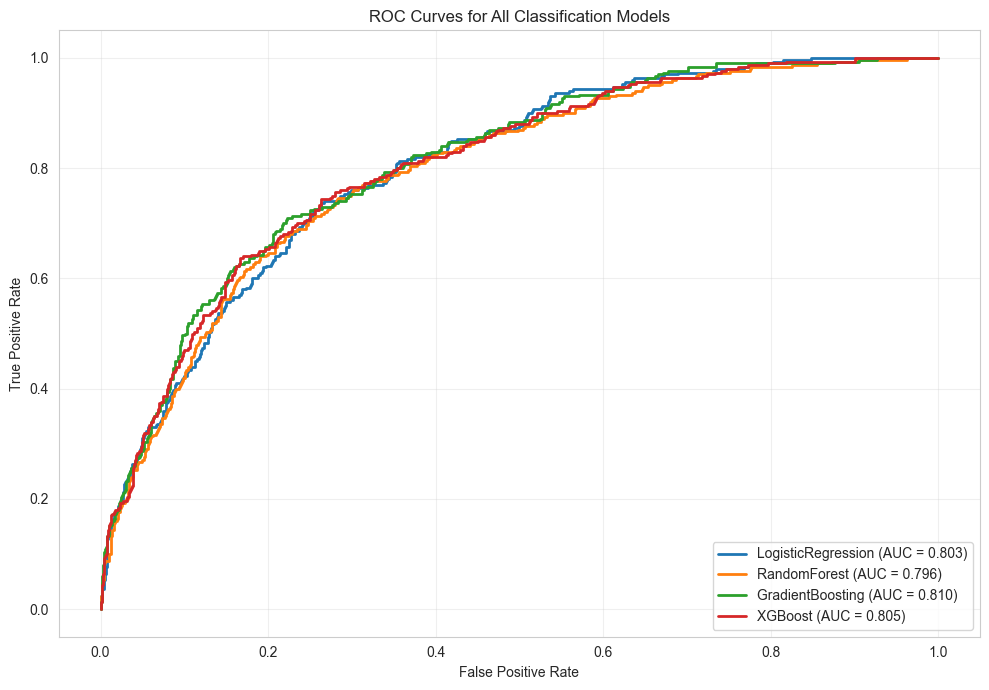

In [65]:

# 7. ROC Curves for all models
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 7))

for name, model in fitted_pipelines.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")


plt.title("ROC Curves for All Classification Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [66]:
columns_to_remove = [
    'sub_grade',             # Redundant with 'grade'
    'state',                 # Too granular, use 'region' instead
    'application_type',      # Usually not discriminative
    'issue_month',           # Time-specific, not customer characteristic
    'year', 'month',         # Time variables, not customer traits
    'loan_status',           # This is outcome, not input feature
    'initial_listing_status', # Platform-specific, not customer trait
    'disbursement_method',   # Operational, not customer characteristic
    'emp_category',          # Likely derived from emp_length
    'grade',
    'loan_grade_status',     # Seems derived/redundant
    
    # Payment history (outcome variables, not predictive features)
    'balance',
    'paid_total', 
    'paid_principal',
    'paid_interest',
    'paid_late_fees',
    
    # Very granular credit metrics (keep the most important ones)
    'earliest_credit_line',           # Use account age instead
    'months_since_90d_late',          # Keep months_since_last_delinq
    'num_collections_last_12m',       # Keep total_collection_amount_ever
    'months_since_last_credit_inquiry', # Keep inquiries_last_12m
    'num_accounts_120d_past_due',     # Keep 30d version
    'num_active_debit_accounts',      # Focus on credit accounts
    'total_debit_limit',              # Focus on credit metrics
    'num_total_cc_accounts',          # Keep open_credit_lines instead
    'num_open_cc_accounts',           # Redundant
    'num_cc_carrying_balance',        # Use utilization instead
    'num_mort_accounts',              # Not core to unsecured lending
    'tax_liens',                      # Very rare, not discriminative
    'current_installment_accounts',   # Not as important
    'accounts_opened_24m',            # Not as critical
    'num_satisfactory_accounts',      # Use delinq percent instead
    'num_historical_failed_to_pay',  # Use recent delinq instead,
]

In [67]:
# If columns_to_remove is a tuple/list/array of strings:
df_seg = df_seg.drop(columns=pd.Index(columns_to_remove).intersection(df_seg.columns))


In [68]:
numeric_cols = [
    'emp_length', 'annual_income', 'debt_to_income', 'delinq_2y',
    'months_since_last_delinq', 'inquiries_last_12m',
    'total_credit_lines', 'open_credit_lines', 'total_credit_limit',
    'total_credit_utilized', 
    'current_accounts_delinq', 'total_collection_amount_ever',
    'num_accounts_30d_past_due',
    'account_never_delinq_percent', 'public_record_bankrupt',
    'loan_amount', 'term', 'interest_rate', 'installment'
]

df_num = df_seg[numeric_cols]



In [69]:
import numpy as np

# Set your correlation threshold
threshold = 0.8

#Compute the correlation matrix
corr_matrix = df_num.corr().abs()

#Create an upper triangle matrix (to avoid duplicate pairs)
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

#Find columns with correlation greater than the threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print(f"Columns to drop (correlation > {threshold}):")
print(to_drop)

# Drop the highly correlated columns
df_num_reduced = df_num.drop(columns=to_drop)

print(f"\nReduced DataFrame shape: {df_num_reduced.shape}")


Columns to drop (correlation > 0.8):
['installment']

Reduced DataFrame shape: (8505, 18)


In [70]:
# Drop the old numeric columns from the full dataframe
df_seg_reduced = df_seg.drop(columns=df_num.columns, errors='ignore')

# Add the reduced numeric columns back
df_seg_ = pd.concat([df_seg, df_num_reduced], axis=1)

print(f"Final DataFrame shape: {df_seg.shape}")


Final DataFrame shape: (8505, 23)


In [71]:
from sklearn.pipeline import Pipeline

# Identify the model with the smallest AUC drop
best_row = generalization_summary.iloc[0]
best_model_name = best_row["Model"]

print(f"\n🏆 Best Generalising Model: {best_model_name}")

# Get the trained pipeline object
best_model_pipe = fitted_pipelines[best_model_name]

print("\nExtracting PD Scores from Train and Test Sets")
print("="*60)

try:
    print(f"Using best model pipeline: {best_model_name}")

    # --- Auto-detect classifier step ---
    if isinstance(best_model_pipe, Pipeline):
        classifier = best_model_pipe.steps[-1][1]   # last step in pipeline
        print(f"Detected classifier: {classifier.__class__.__name__}")
        model_to_use = best_model_pipe
    else:
        classifier = best_model_pipe
        model_to_use = best_model_pipe
        print(f"Detected standalone model: {classifier.__class__.__name__}")

    # --- Extract PD Scores ---
    pd_scores_train = model_to_use.predict_proba(X_train)[:, 1]
    pd_scores_test  = model_to_use.predict_proba(X_test)[:, 1]

    # --- PD Stats ---
    print("\nPD Scores Extracted:")
    print("Train Set:")
    print(f" - Shape: {pd_scores_train.shape}")
    print(f" - Range: {pd_scores_train.min():.4f} to {pd_scores_train.max():.4f}")
    print(f" - Mean:  {pd_scores_train.mean():.4f}")

    print("\nTest Set:")
    print(f" - Shape: {pd_scores_test.shape}")
    print(f" - Range: {pd_scores_test.min():.4f} to {pd_scores_test.max():.4f}")
    print(f" - Mean:  {pd_scores_test.mean():.4f}")

    # --- Combine results ---
    combined_indices = list(X_train.index) + list(X_test.index)
    pd_score = np.concatenate([pd_scores_train, pd_scores_test])
    combined_targets = np.concatenate([y_train.values, y_test.values])

    pd_results = pd.DataFrame({
        'index': combined_indices,
        'pd_score': pd_score,
        'actual_default': combined_targets,
        'data_split': ['train'] * len(X_train) + ['test'] * len(X_test)
    })

    print("\nPD Results DataFrame created:")
    print(f" - Shape: {pd_results.shape}")
    print(f" - Columns: {pd_results.columns.tolist()}")

    display(pd_results.head())
    print("\nPD scores extracted and ready for segmentation analysis")

except Exception as e:
    print(f"ERROR extracting PD scores: {e}")



🏆 Best Generalising Model: LogisticRegression

Extracting PD Scores from Train and Test Sets
Using best model pipeline: LogisticRegression
Detected classifier: LogisticRegression

PD Scores Extracted:
Train Set:
 - Shape: (6804,)
 - Range: 0.0004 to 0.9920
 - Mean:  0.3906

Test Set:
 - Shape: (1701,)
 - Range: 0.0025 to 0.9914
 - Mean:  0.3999

PD Results DataFrame created:
 - Shape: (8505, 4)
 - Columns: ['index', 'pd_score', 'actual_default', 'data_split']


,index,pd_score,actual_default,data_split
0,1239,0.626117,1,train
1,8437,0.271556,0,train
2,9727,0.406318,0,train
3,7158,0.075157,0,train
4,6990,0.593834,0,train



PD scores extracted and ready for segmentation analysis


In [72]:

if 'df_seg' in locals():
    
    # Show all available columns
    print(f"Available columns in df_seg ({len(df_seg.columns)}):")
    for i, col in enumerate(df_seg.columns, 1):
        print(f"  {i:2d}. {col}")
    
    # Define features for clustering (based on your column names)
    # Adjust these based on your actual column names
    numerical_features_clustering = [
        'pd_score',                    # From classification model
        'loan_amount',                 # Loan size
        'interest_rate',               # Return rate
        'annual_income',               # Income
        'debt_to_income',              # Debt ratio
        'installment',                 # Monthly payment
        'total_credit_limit',          # Credit capacity
        'total_credit_utilized',       # Credit usage
        'delinq_2y',                   # Recent delinquencies
        'inquiries_last_12m',          # Credit inquiries
        'open_credit_lines',           # Open accounts
        'total_credit_lines',          # Total accounts
        # Add other numerical columns you want to include
    ]
    
    categorical_features_clustering = [
        'homeownership',               # Home ownership
        'emp_length',                  # Employment length
        'verified_income',             # Income verification
        'loan_purpose',                # Loan purpose
        'term',                        # Loan term

        'region'                   # Geographic region
        # Add other categorical columns you want to include
    ]
    
    # Filter to existing columns
    existing_numerical = [col for col in numerical_features_clustering if col in df_seg.columns]
    existing_categorical = [col for col in categorical_features_clustering if col in df_seg.columns]
    
    print(f"\nFeatures selected for clustering:")
    print(f"  - Numerical features ({len(existing_numerical)}): {existing_numerical}")
    print(f"  - Categorical features ({len(existing_categorical)}): {existing_categorical}")
    
    # Create clustering subset
    all_clustering_features = existing_numerical + existing_categorical
    df_seg_clustering = df_seg[all_clustering_features].copy()
    
    print(f"\nFinal clustering dataset (df_seg_clustering):")
    print(f"  - Shape: {df_seg_clustering.shape}")
    print(f"  - Total features: {len(all_clustering_features)}")
    print(f"  - Includes PD scores: {'pd_score' in df_seg_clustering.columns}")
    
    # Check missing values
    missing_counts = df_seg_clustering.isnull().sum()
    high_missing = missing_counts[missing_counts > len(df_seg_clustering) * 0.1]
    
    if len(high_missing) > 0:
        print(f"\n  Features with >10% missing values:")
        for feature, count in high_missing.items():
            pct = (count / len(df_seg_clustering)) * 100
            print(f"    - {feature}: {pct:.1f}% missing")
    else:
        print(f"\n All features have <10% missing values")
    
    print(f"  1. Preprocessing (imputation + scaling + encoding)")
    print(f"  2. PCA for dimensionality reduction") 
    print(f"\nDataset: {len(df_seg_clustering):,} customers with {len(all_clustering_features)} features")
    
else:
    print(" df_seg not available. Please run the previous steps first.")
# STEP 1: Add PD Scores to Segmentation Dataset
print("\n🔄 ADDING PD SCORES TO SEGMENTATION DATASET")
print("=" * 55)

if 'pd_results' in locals() and 'df_seg' in locals():

    print(f"Before merge:")
    print(f"  - df_seg shape: {df_seg.shape}")
    print(f"  - pd_results shape: {pd_results.shape}")

    # Reset index of df_seg for merging
    df_seg_reset = df_seg.reset_index()

    # Merge PD scores and data_split back
    df_seg = df_seg_reset.merge(
        pd_results[['index', 'pd_score', 'data_split']],
        on='index', how='left'
    ).set_index('index')

    print(f"\nAfter merge:")
    print(f"  - df_seg shape: {df_seg.shape}")
    print(f"  - PD score present: {'pd_score' in df_seg.columns}")

    # Basic stats
    if 'pd_score' in df_seg.columns:
        stats = df_seg['pd_score'].describe()
        print(f"\nPD Score Summary:")
        for stat, val in stats.items():
            print(f"  {stat.capitalize():<10}: {val:.4f}")
        print(f"  Missing: {df_seg['pd_score'].isna().sum()}")

    display(df_seg[['pd_score', 'data_split']].head())

else:
    raise ValueError("Missing df_seg or pd_results. Ensure both are loaded.")
print("\n Building preprocessing pipeline (excluding PD score from PCA)")



Available columns in df_seg (23):
   1. emp_length
   2. homeownership
   3. annual_income
   4. verified_income
   5. debt_to_income
   6. delinq_2y
   7. months_since_last_delinq
   8. inquiries_last_12m
   9. total_credit_lines
  10. open_credit_lines
  11. total_credit_limit
  12. total_credit_utilized
  13. current_accounts_delinq
  14. total_collection_amount_ever
  15. num_accounts_30d_past_due
  16. account_never_delinq_percent
  17. public_record_bankrupt
  18. loan_purpose
  19. loan_amount
  20. term
  21. interest_rate
  22. installment
  23. region

Features selected for clustering:
  - Numerical features (11): ['loan_amount', 'interest_rate', 'annual_income', 'debt_to_income', 'installment', 'total_credit_limit', 'total_credit_utilized', 'delinq_2y', 'inquiries_last_12m', 'open_credit_lines', 'total_credit_lines']
  - Categorical features (6): ['homeownership', 'emp_length', 'verified_income', 'loan_purpose', 'term', 'region']

Final clustering dataset (df_seg_clustering)

,pd_score,data_split
index,,
0,0.914650,train
1,0.122590,train
2,0.884011,train
3,0.123314,train
5,0.035372,test



 Building preprocessing pipeline (excluding PD score from PCA)


Numeric features used: ['emp_length', 'annual_income', 'debt_to_income', 'delinq_2y', 'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines', 'total_credit_limit', 'total_credit_utilized', 'current_accounts_delinq', 'total_collection_amount_ever', 'num_accounts_30d_past_due', 'account_never_delinq_percent', 'public_record_bankrupt', 'loan_amount', 'term', 'interest_rate', 'installment']
Categorical features used: ['homeownership', 'verified_income', 'months_since_last_delinq', 'loan_purpose', 'region']
✅ Feature matrix shape: (8505, 127)


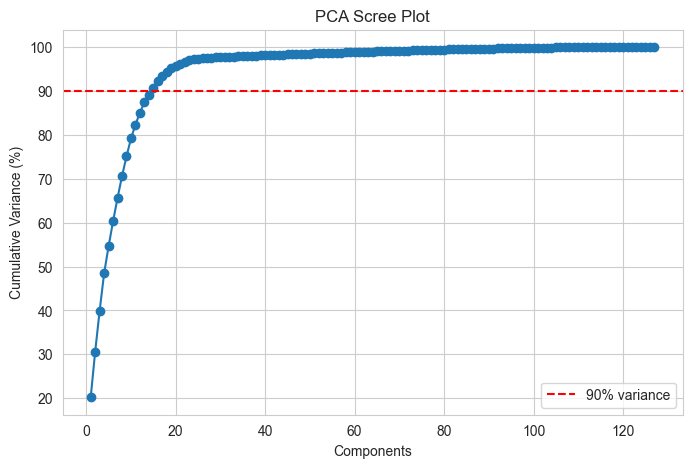

Selected components: 15
Variance explained by 15 components: 90.79%

 Combining PCA features with PD score for clustering
Final clustering matrix shape: (8505, 16)


In [73]:




# Expected columns
expected_numeric = [
    'emp_length', 'annual_income', 'debt_to_income', 'delinq_2y',
    'inquiries_last_12m', 'total_credit_lines', 'open_credit_lines',
    'total_credit_limit', 'total_credit_utilized', 'current_accounts_delinq',
    'total_collection_amount_ever', 'num_accounts_30d_past_due',
    'account_never_delinq_percent', 'public_record_bankrupt',
    'loan_amount', 'term', 'interest_rate', 'installment',
    'amount_per_month'
]

expected_categorical = [
    'homeownership', 'verified_income', 'months_since_last_delinq',
    'loan_purpose', 'region'
]

# Filter only existing
numeric_features = [c for c in expected_numeric if c in df_seg.columns]
categorical_features = [c for c in expected_categorical if c in df_seg.columns]

print("Numeric features used:", numeric_features)
print("Categorical features used:", categorical_features)

# Define transformations
num_pipe = Pipeline([('scaler', StandardScaler())])
cat_pipe = Pipeline([('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numeric_features),
    ('cat', cat_pipe, categorical_features)
])

# Apply transformation
X_processed = preprocessor.fit_transform(df_seg)

# Feature names
encoded_names = []
if categorical_features:
    encoded_names = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, encoded_names])

print(f"✅ Feature matrix shape: {X_processed.shape}")


# STEP 3: PCA on borrower features (excluding PD)
# 
pca_full = PCA(random_state=random_state)
pca_full.fit(X_processed)

cumulative_var = np.cumsum(pca_full.explained_variance_ratio_) * 100

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o')
plt.axhline(90, color='r', linestyle='--', label='90% variance')
plt.xlabel('Components')
plt.ylabel('Cumulative Variance (%)')
plt.title('PCA Scree Plot')
plt.legend()
plt.grid(True)
plt.show()

# Choose minimum components explaining ≥90%
n_components = np.argmax(cumulative_var >= 90) + 1
print(f"Selected components: {n_components}")

pca = PCA(n_components=n_components, random_state=random_state)
X_reduced = pca.fit_transform(X_processed)

df_seg['PCA1'] = X_reduced[:, 0]
df_seg['PCA2'] = X_reduced[:, 1]
print(f"Variance explained by {n_components} components: {cumulative_var[n_components-1]:.2f}%")

# 
# STEP 4: Combine PCA + PD score for KMeans clustering
# 
print("\n Combining PCA features with PD score for clustering")

if 'pd_score' not in df_seg.columns:
    raise ValueError("PD score missing — cannot include in clustering.")

# Standardize PD score separately
pd_scaled = StandardScaler().fit_transform(df_seg[['pd_score']])
X_cluster = np.hstack([X_reduced, pd_scaled])

print(f"Final clustering matrix shape: {X_cluster.shape}")



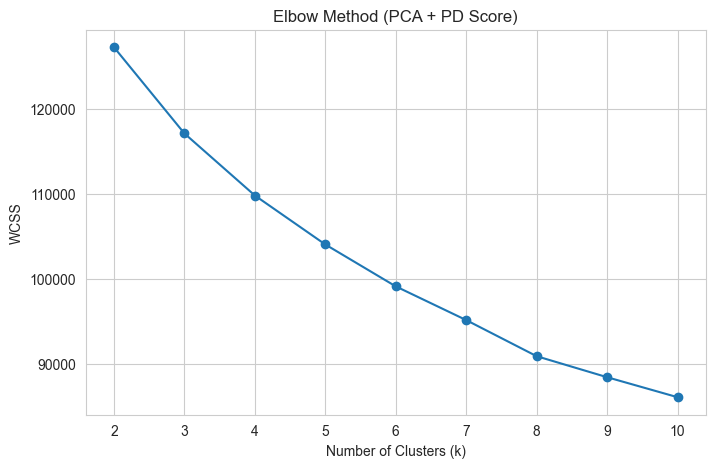

✅ Using optimal k = 4


In [74]:
# STEP 5: Elbow Method

wcss = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    km.fit(X_cluster)
    wcss.append(km.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.title("Elbow Method (PCA + PD Score)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.grid(True)
plt.show()

optimal_k = 4  # Adjust based on elbow chart
print(f"✅ Using optimal k = {optimal_k}")


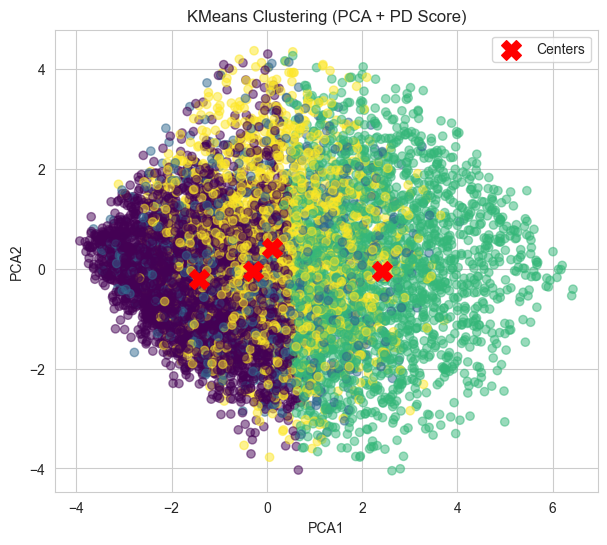


Cluster Summary by PD score:


,cluster,mean,count,risk_level
2,2,0.255870,2046,Low
0,0,0.286455,3397,Moderate
1,1,0.409589,1065,High
3,3,0.703532,1997,Very High



💾 Segmentation complete: 'borrower_clusters_with_pd.csv' saved.


In [75]:

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_seg['cluster'] = kmeans_final.fit_predict(X_cluster)

# Visualize PCA plane (PD not plotted)
plt.figure(figsize=(7, 6))
plt.scatter(df_seg['PCA1'], df_seg['PCA2'], c=df_seg['cluster'], cmap='viridis', alpha=0.5)
plt.scatter(kmeans_final.cluster_centers_[:, 0], kmeans_final.cluster_centers_[:, 1],
            c='red', s=200, marker='X', label='Centers')
plt.title("KMeans Clustering (PCA + PD Score)")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()
plt.show()

# Cluster risk summary (by PD)
summary = df_seg.groupby('cluster')['pd_score'].agg(['mean', 'count']).reset_index()
summary = summary.sort_values('mean')
summary['risk_level'] = ['Low', 'Moderate', 'High', 'Very High'][:len(summary)]
print("\nCluster Summary by PD score:")
display(summary)

risk_map = dict(zip(summary['cluster'], summary['risk_level']))
df_seg['risk_level'] = df_seg['cluster'].map(risk_map)


df_seg.to_csv("borrower_clusters_with_pd.csv", index=False)
print("\n💾 Segmentation complete: 'borrower_clusters_with_pd.csv' saved.")
